# NBA Data :: Home vs Away Analysis

## Trevor Rowland, Abhishek Menothu, Johnathen Wigfall, Scott Campbell :: 2-18-2025

This notebook covers data transformation, data visualization, and hypothesis testing of NBA game data from 2004 to 2024. The goal of this analysis is to see if there is a meaningful difference in a team playing at home vs on the road.

## 1. Importing Packages and Data

In [4]:
import numpy as np
import pandas as pd

from scipy import stats as stats
from scipy.stats import shapiro
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgo

sns.set_style('darkgrid')

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [6]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

In [7]:
df.head(10)

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0
5,40400402,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,62.0,0.468,...,0.0,0.468,0.0,0.0,0.0,76.0,1,1,1,0
6,40400401,2004-05,1610612759,Spurs,SAS,spurs,240:00,34.0,79.0,0.430,...,0.0,0.430,0.0,0.0,0.0,69.0,1,1,1,0
7,40400307,2004-05,1610612748,Heat,MIA,heat,240:00,32.0,69.0,0.464,...,0.0,0.464,0.0,0.0,0.0,88.0,1,0,1,0
8,40400306,2004-05,1610612765,Pistons,DET,pistons,240:00,36.0,86.0,0.419,...,0.0,0.419,0.0,0.0,0.0,66.0,1,1,1,0
9,40400305,2004-05,1610612748,Heat,MIA,heat,240:00,36.0,69.0,0.522,...,0.0,0.522,0.0,0.0,0.0,76.0,1,1,1,0


In [8]:
print(df.columns.tolist())

['game_id', 'season', 'team_id', 'team_name', 'tri_code', 'team_slug', 'minutes', 'field_goals_made', 'field_goals_attempted', 'field_goals_percentage', 'three_pointers_made', 'three_pointers_attempted', 'three_pointers_percentage', 'free_throws_made', 'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive', 'rebounds_defensive', 'rebounds_total', 'steals', 'blocks', 'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'estimated_offensive_rating', 'offensive_rating', 'estimated_defensive_rating', 'defensive_rating', 'estimated_net_rating', 'net_rating', 'assist_percentage', 'assist_to_turnover', 'assist_ratio', 'offensive_rebound_percentage', 'defensive_rebound_percentage', 'rebound_percentage', 'estimated_team_turnover_percentage', 'turnover_ratio', 'effective_field_goal_percentage', 'true_shooting_percentage', 'usage_percentage', 'estimated_usage_percentage', 'estimated_pace', 'pace', 'pace_per40', 'possessions', 'p_i_e', 'distance', 'rebound_chances_offensi

Let's briefly make sure the data is clean. We can use the `missingno` package to view the dataset, and some `pandas` commands to numerically identify missing data and remove it.

<Axes: >

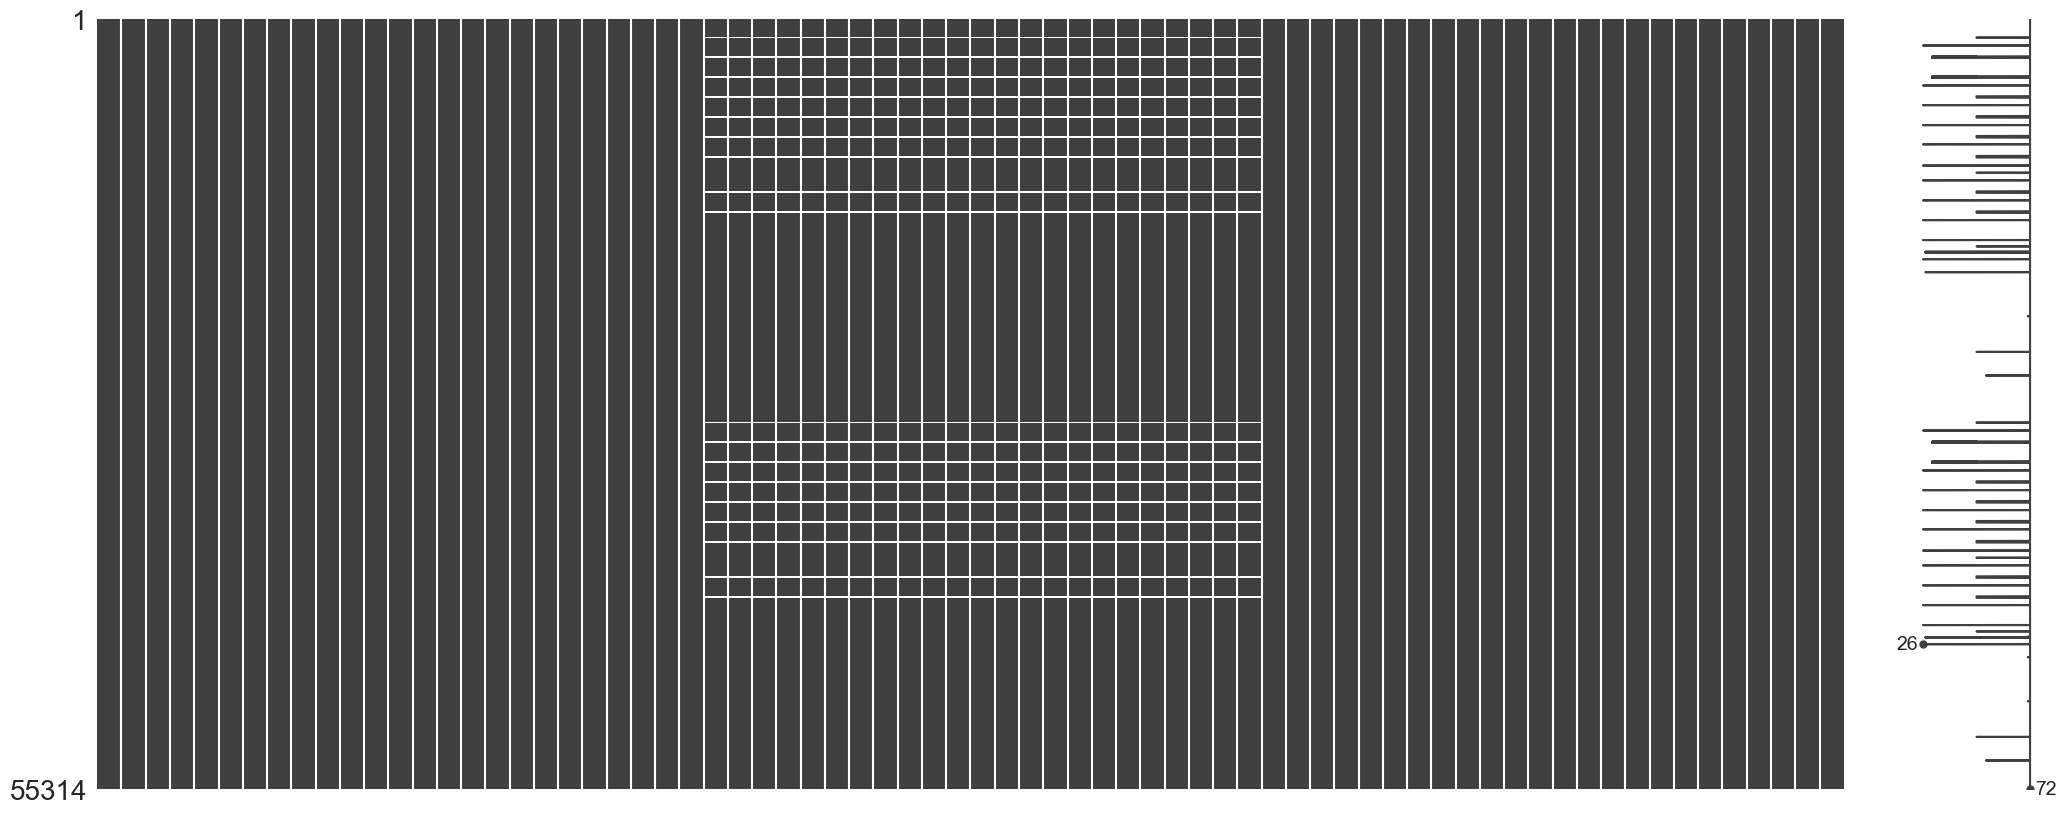

In [9]:
msgo.matrix(df)

The white lines in the center of this chart are empty data, so there is some missing data to handle. Let's examine the sum of the missing values, and the percentage of NA values to see if we can jsut drop the missing data.

In [10]:
print(f'There are {df.isna().sum().sum()} Missing Values.')

There are 49389 Missing Values.


In [11]:
nan_counts_df = pd.DataFrame({'Column': df.isna().sum().index, 'NaN Count': df.isna().sum().values})
nan_counts_df['NaN Percentage'] = (nan_counts_df['NaN Count'] / len(df)) * 100
nan_counts_df.sort_values(by='NaN Percentage', ascending=False).T # added .T to avoid truncation, change if we want to include in the presentation

,36,25,27,28,29,30,31,32,33,35,...,8,7,5,70,69,68,0,1,2,71
Column,rebound_percentage,estimated_offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,defensive_rebound_percentage,...,field_goals_attempted,field_goals_made,team_slug,is_playoff_game,won_game,is_home_team,game_id,season,team_id,is_regular_game
NaN Count,2045,2045,2045,2045,2045,2045,2045,2045,2045,2045,...,27,27,27,0,0,0,0,0,0,0
NaN Percentage,3.697075,3.697075,3.697075,3.697075,3.697075,3.697075,3.697075,3.697075,3.697075,3.697075,...,0.048812,0.048812,0.048812,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
cleaned = df.dropna()

<Axes: >

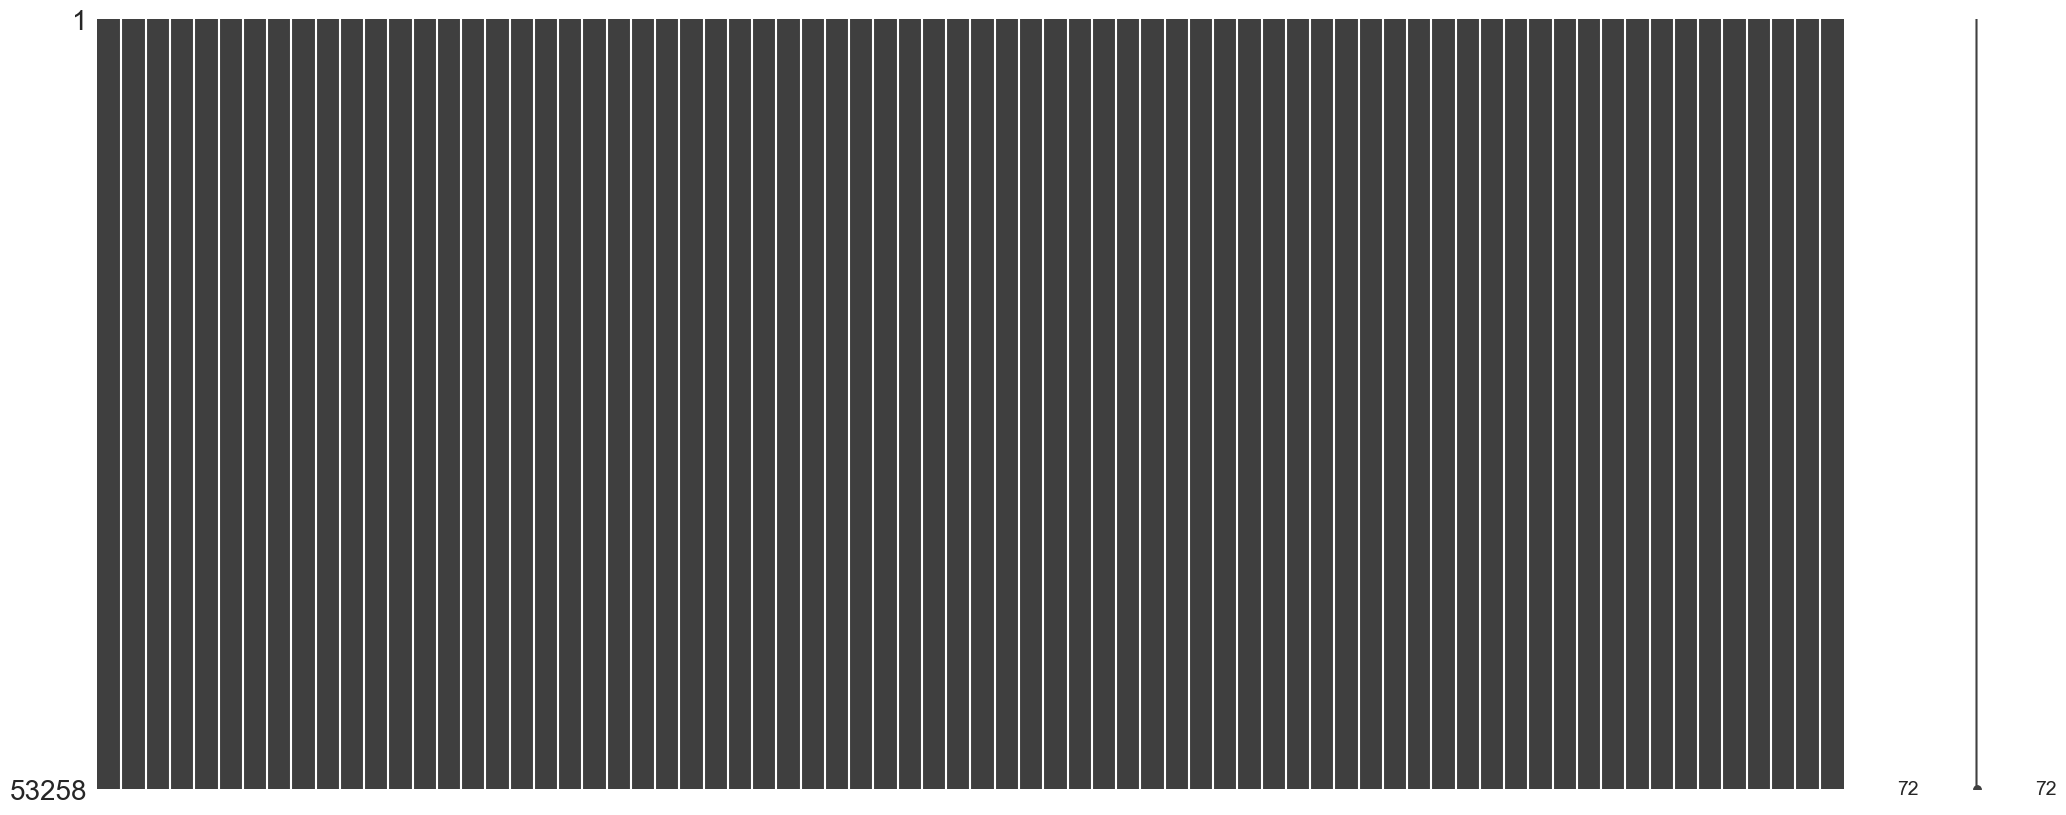

In [13]:
msgo.matrix(cleaned)

It looks like we have at most, 3% of data missing from different columns. This is a trivial amountof missing data, so we can safely drop it from the df and likely not experience serious bias or error from this.

In [14]:
rownums_post_drop, colnums_post_drop = cleaned.shape
print(f'there are now {colnums_post_drop} columns and {rownums_post_drop} rows in the DataFrame vs. {df.shape[0]} rows initially.')

there are now 72 columns and 53258 rows in the DataFrame vs. 55314 rows initially.


## 2. Examining Win Percentages For Teams

### 2.a. Calculating Win Percentages

To examine the win percentages of home and away games, we need to group the dataset by season, ~~count all of the wins at home and wins away, then divide that by the number of games in that season.~~

Edit: We can create the win percentage for home games by finding the mean of the win counts for home games, then do the same for away games.

In [15]:
# Create an Empty dict to build the aggregated df for win %
agg_df = {}

# SAC Method
vars_of_interest = ['game_id','is_home_team','won_game','season']

df_sac = cleaned[vars_of_interest] # create a df of just the win % stuff
df_sac.head()

,game_id,is_home_team,won_game,season
0,40400407,1,1,2004-05
1,40400406,1,0,2004-05
2,40400405,1,0,2004-05
3,40400404,1,1,2004-05
4,40400403,1,1,2004-05


In [16]:
# SAC Method Continued (the AC part)
win_percent = (
    df_sac[df_sac["is_home_team"] == 1]  # Filter for home games
    .groupby("season")["won_game"]       # Group by season, selecting only won_game
    .mean()                              # Compute win percentage
    .reset_index()                       # Convert back to DataFrame
)

win_percent.rename(columns={"won_game": "home_win_pct"}, inplace=True)

# Let's also add away win pct in case we do a stacked bar chart
win_percent['away_win_pct'] = 1 - win_percent['home_win_pct']
win_percent

,season,home_win_pct,away_win_pct
0,2004-05,0.601824,0.398176
1,2005-06,0.607873,0.392127
2,2006-07,0.595728,0.404272
3,2007-08,0.610015,0.389985
4,2008-09,0.612167,0.387833
5,2009-10,0.598174,0.401826
6,2010-11,0.607768,0.392232
7,2011-12,0.593488,0.406512
8,2012-13,0.613982,0.386018
9,2013-14,0.578350,0.421650


From the data, we can see that the home win percentage (`home_win_pct`) is, on average, decreasing each season. Let's take a look at some visualizations of this data, then dive into factors to try to explain why this is happening.

### 2.b. Visualizations of Win Percentages Over Time

Now that we have the home and away win percentages over time, let's create some visualizations to see what is happening with win rates.

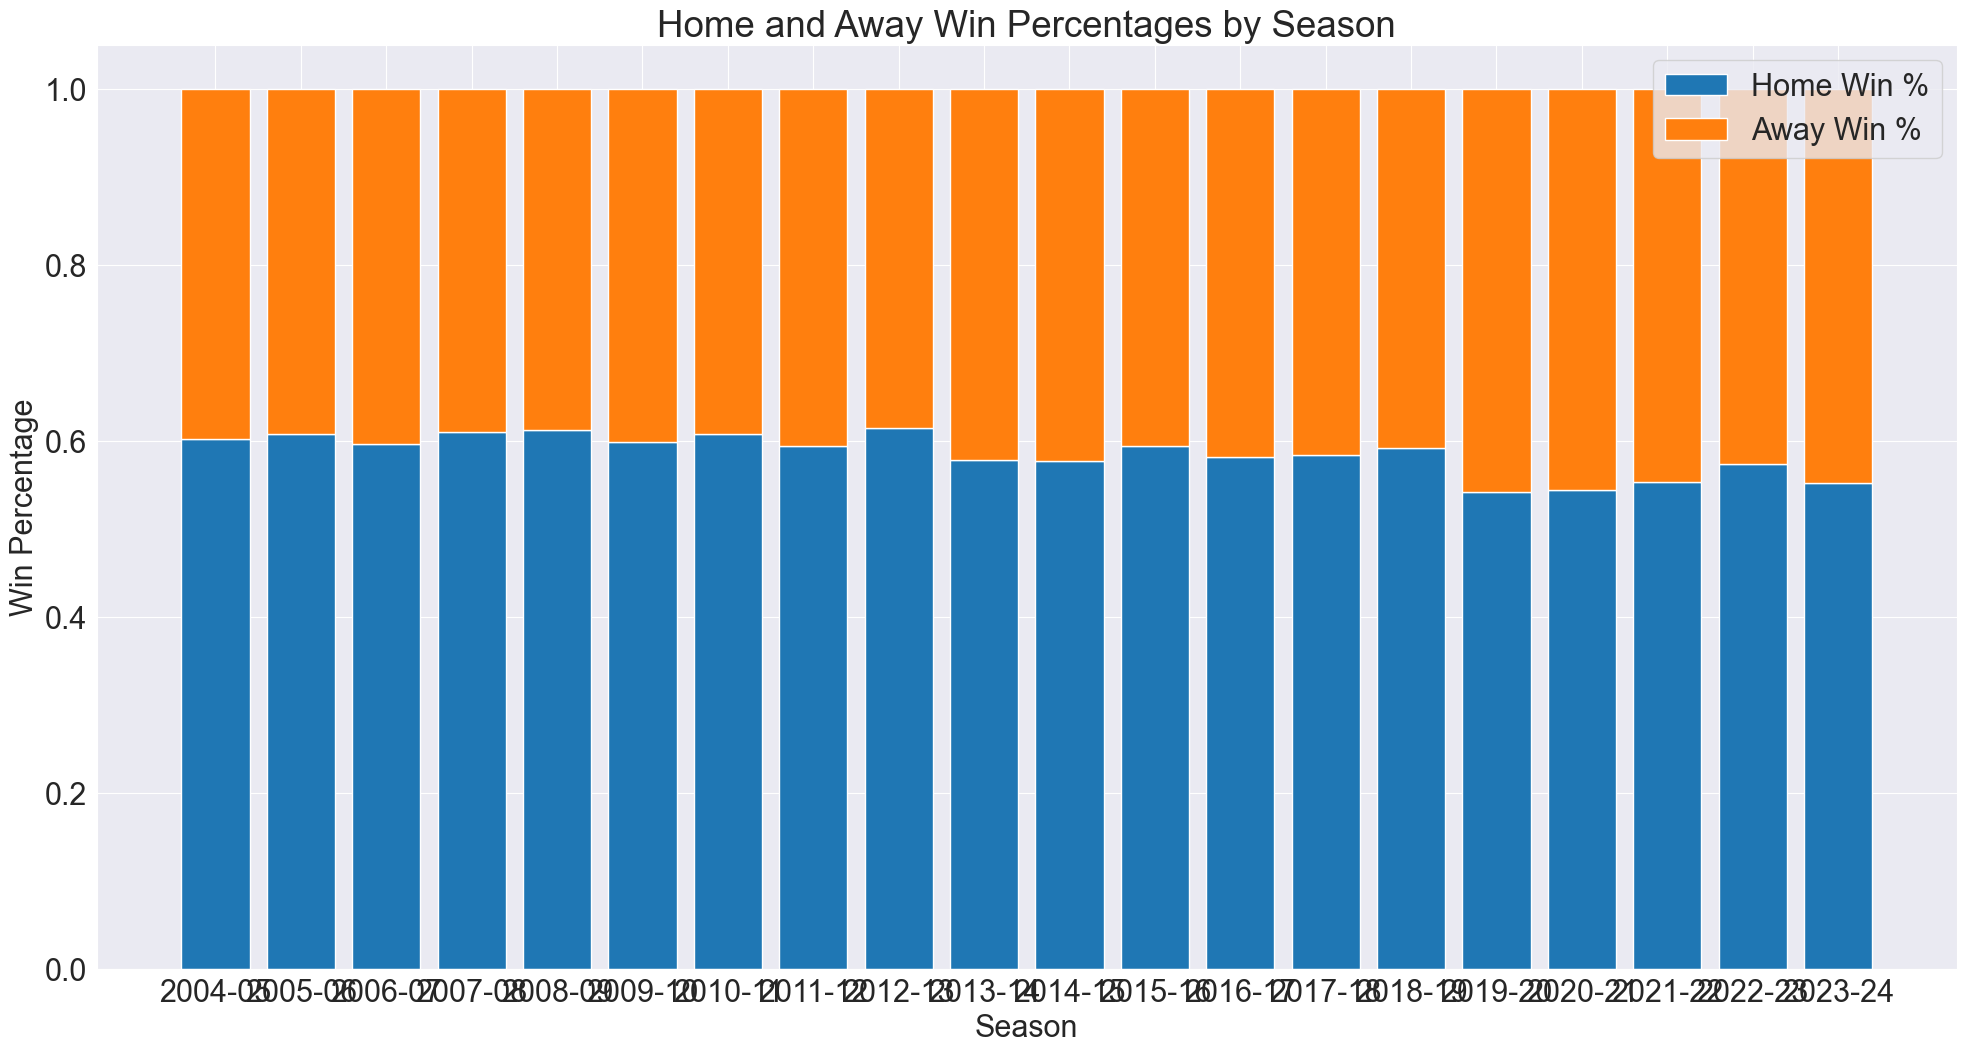

In [17]:
fig, ax = plt.subplots(figsize=(24, 12))

ax.bar(win_percent['season'], win_percent['home_win_pct'], label='Home Win %', color='#1f77b4')
ax.bar(win_percent['season'], win_percent['away_win_pct'], 
       bottom=win_percent['home_win_pct'], label='Away Win %', color='#ff7f0e')

ax.set_ylabel('Win Percentage')
ax.set_xlabel('Season')
ax.set_title('Home and Away Win Percentages by Season')
ax.legend()

plt.show()

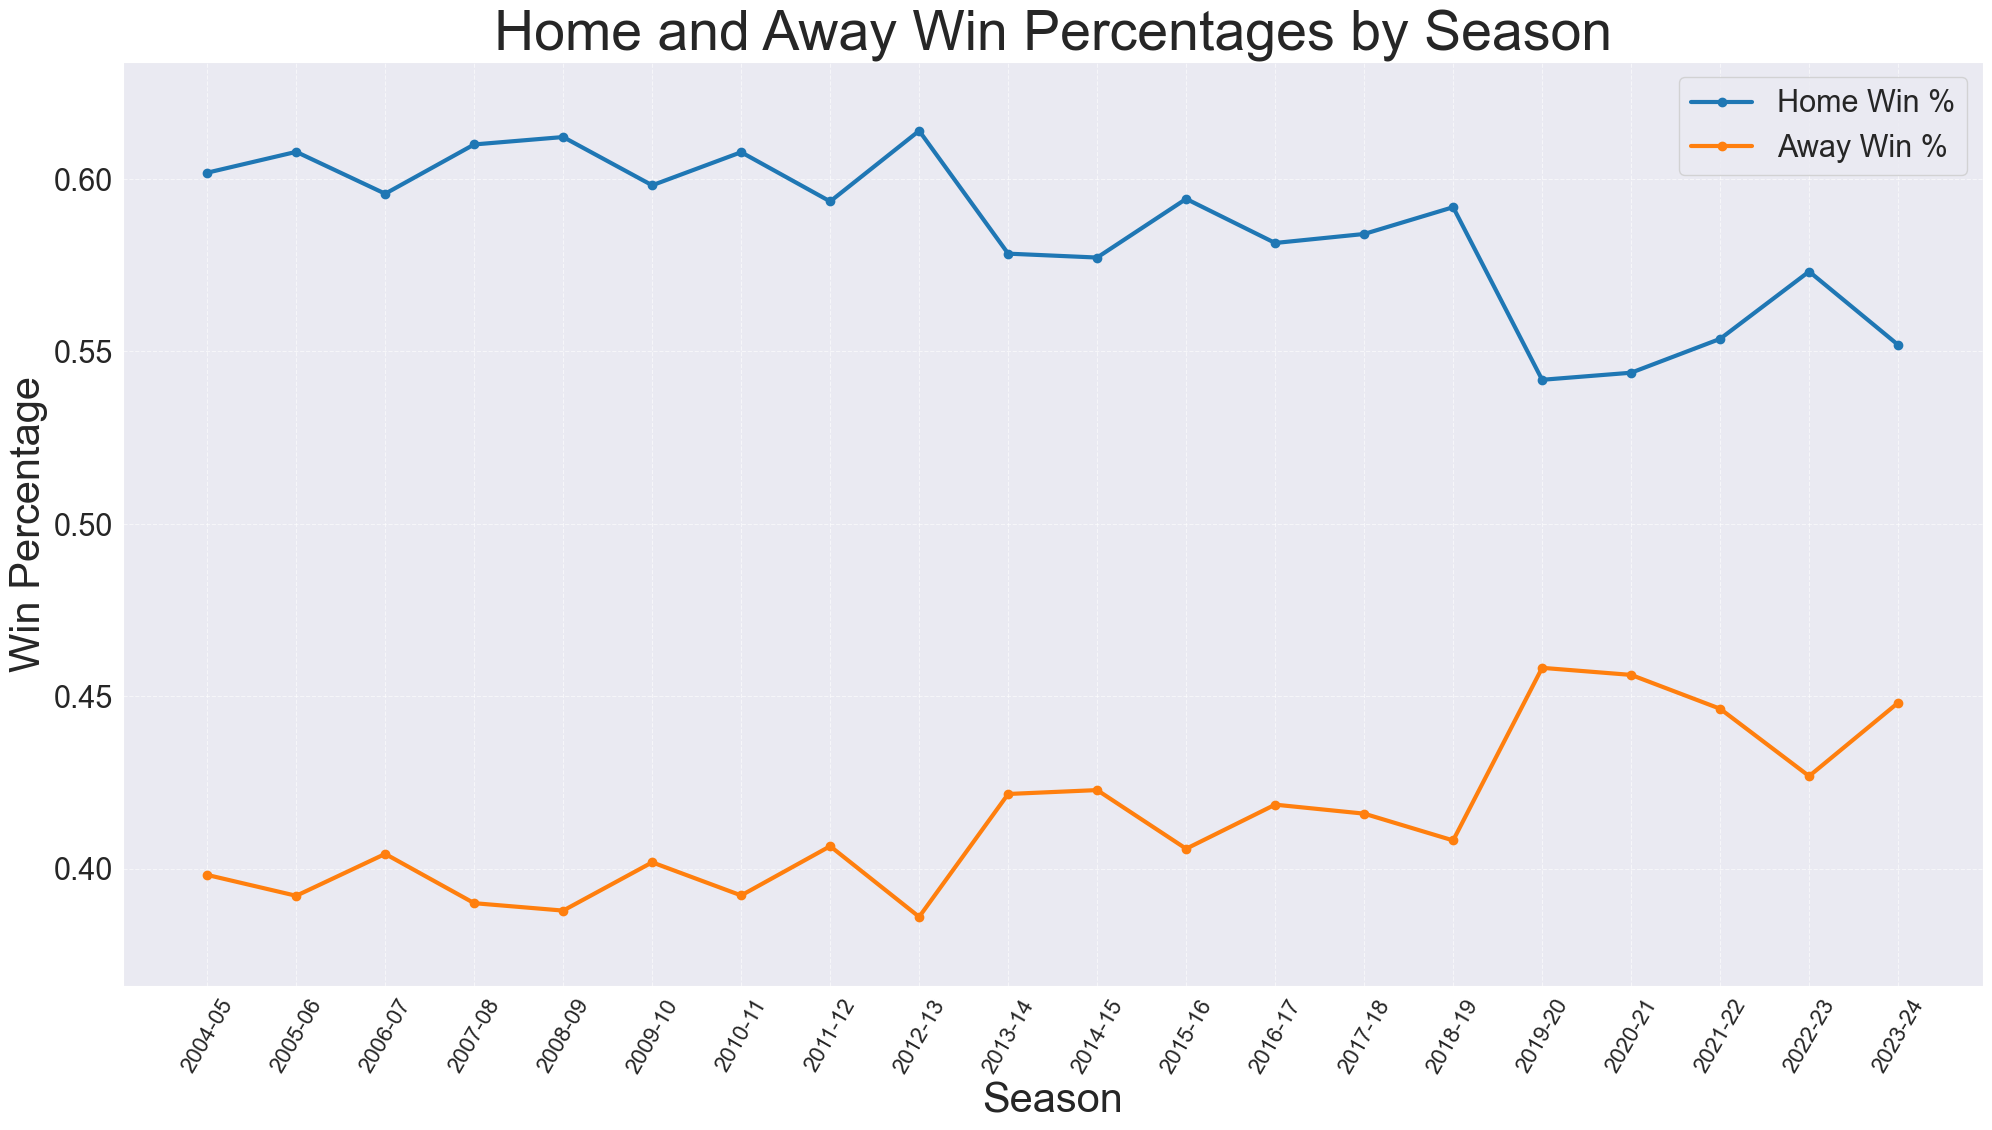

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24, 12))

# Plot win percentages as lines
ax.plot(win_percent['season'], win_percent['home_win_pct'], label='Home Win %', marker='o', color='#1f77b4', linewidth=3)
ax.plot(win_percent['season'], win_percent['away_win_pct'], label='Away Win %', marker='o', color='#ff7f0e', linewidth=3)

# Set labels and title
ax.set_ylabel('Win Percentage', fontsize=30)
ax.set_xlabel('Season', fontsize=30)
ax.set_title('Home and Away Win Percentages by Season', fontsize=40)

# Zoom in by adjusting the y-axis limits
ax.set_ylim(win_percent[['home_win_pct', 'away_win_pct']].min().min() - 0.02, 
            win_percent[['home_win_pct', 'away_win_pct']].max().max() + 0.02)

ax.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=60, fontsize=16)

plt.show()

This chart muddies the waters a bit. From the DataFrame, we do see a very slight downward trend in the win percentages at home, but the chart has a more uniform distribution. However, doing some additional research the team found Michael MacKelvie's video on Home vs. Away Games, and his data extends as far back as the 1940s. In his video, home win percentages are going down over time. 

We will need to expand our time horizon to confirm there is a more dramatic trend, but for now lets take that slight downward trend and run with it, examining the factors **why** that percent might be going down.

## 3. Factors to Examine

So what is causing this decline that we can examine in our data? We can examine the statistics in our dataset like free throws, 3 pointers, turnovers, and defensive/offensive rebounds to see if the group means and variances between home and away games are the same. If the means are the same, we can intuit that the statistic does not have a meaningful impact on home win percentage. If the means or variances are not the same, then we can infer that they have a meaningful impact on a teams win percentage at home or away.

### 3.a. Splitting DataFrames into Home and Away Games

First we need to create 2 DataFrames, 1 for Home and 1 for Away games.

In [19]:
home_df = cleaned[cleaned['is_home_team']==1]
away_df = cleaned[cleaned['is_home_team']==0]

In [20]:
home_df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


In [21]:
away_df.head()


,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
27657,40400407,2004-05,1610612765,Pistons,DET,pistons,240:00,31.0,74.0,0.419,...,0.0,0.419,0.0,0.0,0.0,81.0,0,0,1,0
27658,40400406,2004-05,1610612765,Pistons,DET,pistons,240:00,37.0,79.0,0.468,...,0.0,0.468,0.0,0.0,0.0,86.0,0,1,1,0
27659,40400405,2004-05,1610612759,Spurs,SAS,spurs,265:00,38.0,82.0,0.463,...,0.0,0.463,0.0,0.0,0.0,95.0,0,1,1,0
27660,40400404,2004-05,1610612759,Spurs,SAS,spurs,240:00,26.0,70.0,0.371,...,0.0,0.371,0.0,0.0,0.0,102.0,0,0,1,0
27661,40400403,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,67.0,0.433,...,0.0,0.433,0.0,0.0,0.0,96.0,0,0,1,0


Lastly, we will filter down the DataFrames into just the columns we wish to examine.

In [22]:
cols_of_interest = ['game_id',
                    'season',
                    'tri_code',
                    'field_goals_percentage',
                    'three_pointers_percentage',
                    'free_throws_percentage',
                    'rebounds_offensive',
                    'rebounds_defensive',
                    'contested_field_goal_percentage',
                    'uncontested_field_goals_percentage',
                    ]

home_df_filtered = home_df[cols_of_interest]
away_df_filtered = away_df[cols_of_interest]

Let's break the data down further into `pandas.Series` objects to pass into the plotting and statistical testing functions we will define in the next section.

In [23]:
# Field Goal Percentage
home_fg_pct = home_df['field_goal_percentage']
away_fg_pct = away_df['field_goal_percentage']
l_fg = [home_fg_pct, away_fg_pct]

# Three-Pointer Percentage
home_tp_pct = home_df['three_pointers_percentage']
away_tp_pct = away_df['three_pointers_percentage']
l_tp = [home_tp_pct, away_tp_pct]

# Free-Throw Percentage
home_ft_pct = home_df['free_throws_percentage']
away_ft_pct = away_df['free_throws_percentage']
l_ft = [home_ft_pct, away_ft_pct]

# Offensive Rebounds
home_r_off = home_df['rebounds_offensive']
away_r_off = away_df['rebounds_offensive']
l_r_off = [home_r_off, away_r_off]

# Defensive Rebounds
home_r_def = home_df['rebounds_defensive']
away_r_def = away_df['rebounds_defensive']
l_r_def = [home_r_def, away_r_def]

# Contested Field Goals
home_cfg_pct = home_df['contested_field_goal_percentage']
away_cfg_pct = away_df['contested_field_goal_percentage']
l_cfg = [home_cfg_pct, away_cfg_pct]

# Uncontested Field Goals
home_ufg_pct = home_df['uncontested_field_goals_percentage']
away_ufg_pct = away_df['uncontested_field_goals_percentage']
l_ufg = [home_ufg_pct, away_ufg_pct]

## 4. Normality Testing

Now that we have cleaned home and away game DataFrames, we can begin to create hypothesis tests. The following sections will examine the distributions to test for normality, to determine whether we need to use parametric or non-parametric tests.

We will create lists to store the results for a crosstab as well.

### 4.a. Examining Distributions

We will construct Histograms and QQ Plots of each variable of interest in this section. The following cells will define functions to plot these charts, and break the dataframe into lists of data to chart in the histograms.

In [24]:
def side_by_side_hists(l:list, titles:list):
    # Create a figure and axis objects
    fig, axs = plt.subplots(1, 2, figsize=(25, 10))

    # Loop through the subplots and add the histograms
    sns.histplot(data=l[0].dropna(), ax=axs[0], bins=50, kde=True, color='#2142ab')
    sns.histplot(data=l[1].dropna(), ax=axs[1], bins=50, kde=True, color='#2142ab')

    # Assign Titles
    axs[0].set_title(f'{titles[0]} - 2004-2024')
    axs[1].set_title(f'{titles[1]} - 2004-2024')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
    return


In [25]:
def side_by_side_qq_plots(l:list, titles:list):
    # Generate a Normal Distribution for the QQ Plots
    mean = 0  # Normal Dists are mean=0, stddev=1
    std_dev = 1
    size = 100  # len of arr
    normal_data = np.random.normal(loc=mean, scale=std_dev, size=size)
    normal_series = pd.Series(normal_data) # convert to series to match format

    # Set up the panel
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(40,10), squeeze=False)

    # Add titles
    axs[0][0].set_title(f'Normal Dist. vs. {titles[0]} - 2004-2024')
    axs[0][1].set_title(f'Normal Dist. vs. {titles[1]} - 2004-2024')
    axs[0][2].set_title('Normal Dist. vs. Normal Dist.')

    # Plot Data
    sm.qqplot(l[0],dist=stats.norm,ax=axs[0][0],line='45')
    sm.qqplot(l[1],dist=stats.norm,ax=axs[0][1],line='45')
    sm.qqplot(normal_series,dist=stats.norm,ax=axs[0][2],line='45')

    plt.show()

Visualizations are not enough to confirm the data is normally distributed though. To confirm the results of the charts, we will define functions to run the **Shapiro-Wilk** test of Normality, the **Anderson-Darling** test, which tests if a sample is from a given probablity distribution. Both tests are needed due to the large sample size of the data, after $N > 5000$ the Shapiro-Wilk test may provide an inaccurate p-value.

**Shapiro-Wilk Test**

The Shapiro-Wilk Test of Normality is defined as:

$$
\begin{align*}
H_0 &\text{: The data has been sampled from a normal distribution, } N(\mu,\sigma^2) \\
H_1 &\text{: The data has has not been sampled from a normal distribution, } N(\mu,\sigma^2)
\end{align*}
$$

The test is run by computing a test statistic, $W$, and returns a $p$-value for us to interpret. From this test, a $p$-value below the significance level tells us to reject the null hypothesis $H_0$, and *we cannot assume Normality*.

We are using `scipy.stats`'s `shapiro` function to run this test, then the function will print the results in a more readable format.

In [26]:
def run_shapiro_test(l:list):
    from scipy.stats import shapiro
    w_home = shapiro(l[0])
    w_away = shapiro(l[1])

    print(f'Home Games:\n  Test Stat (W): {w_home.statistic},\n  p-value: {w_home.pvalue}\n')
    print(f'Away Games:\n  Test Stat (W): {w_away.statistic},\n  p-value: {w_away.pvalue}\n')

    return w_home, w_away

**Anderson-Darling Test**

The Shapiro-Wilk Test is useful for determining normality of a sample, but has one fatal flaw: *it produces inaccurate p-values for* $N > 5000$. This means another test, the Anderson-Darling (AD) Test, must be used. The Anderson-Darling Test is as follows:

$$
\begin{align*}
H_0&\text{: The data comes from the chosen (normal) distribution} \\
H_1&\text{: The data does not come from the chosen (normal) distribution} \\
\end{align*}
$$

AD Testing checks if a sample comes from a provided distribution. Meaning, we can provide a sample to it along with a desired distribution to test (The normal distribution $N$ in our case), and get a result of whether our sample comes from the desired distribution or not.

We are again using `scipy.stats` for this test, using the `anderson` function. The function returns the test statistic, an array of critical values and an array of significance levels. *If the returned test statistic is larger than the critical values for the corresponding significance levels, then the null hypothesis should be rejected.*

In [27]:
def run_ad_test(l:list):
    from scipy.stats import anderson
    home = anderson(l[0],dist='norm')
    away = anderson(l[1],dist='norm')

    print(f'Home Games:\n  Test Statistic: {home.statistic},\n  Critical Values: {home.critical_values},\n  Significance Level: {home.significance_level}\n')
    print(f'Home Games:\n  Test Statistic: {away.statistic},\n  Critical Values: {away.critical_values},\n  Significance Level: {away.significance_level}\n')

    return home, away

###### 3/31/25 :: 

Test the following features:

- field goals made
- field goals attempted
- Uncontested Field Goals Attempted

In [57]:
home_fgm_df = home_df['field_goals_made']
away_fgm_df = away_df['field_goals_made']
l_fgm = [home_fgm_df, away_fgm_df]

home_fga_df = home_df['field_goals_attempted']
away_fga_df = away_df['field_goals_attempted']
l_fga = [home_fga_df, away_fga_df]

home_ufga_df = home_df['uncontested_field_goals_attempted']
away_ufga_df = away_df['uncontested_field_goals_attempted']
l_ufga = [home_ufga_df, away_ufga_df]

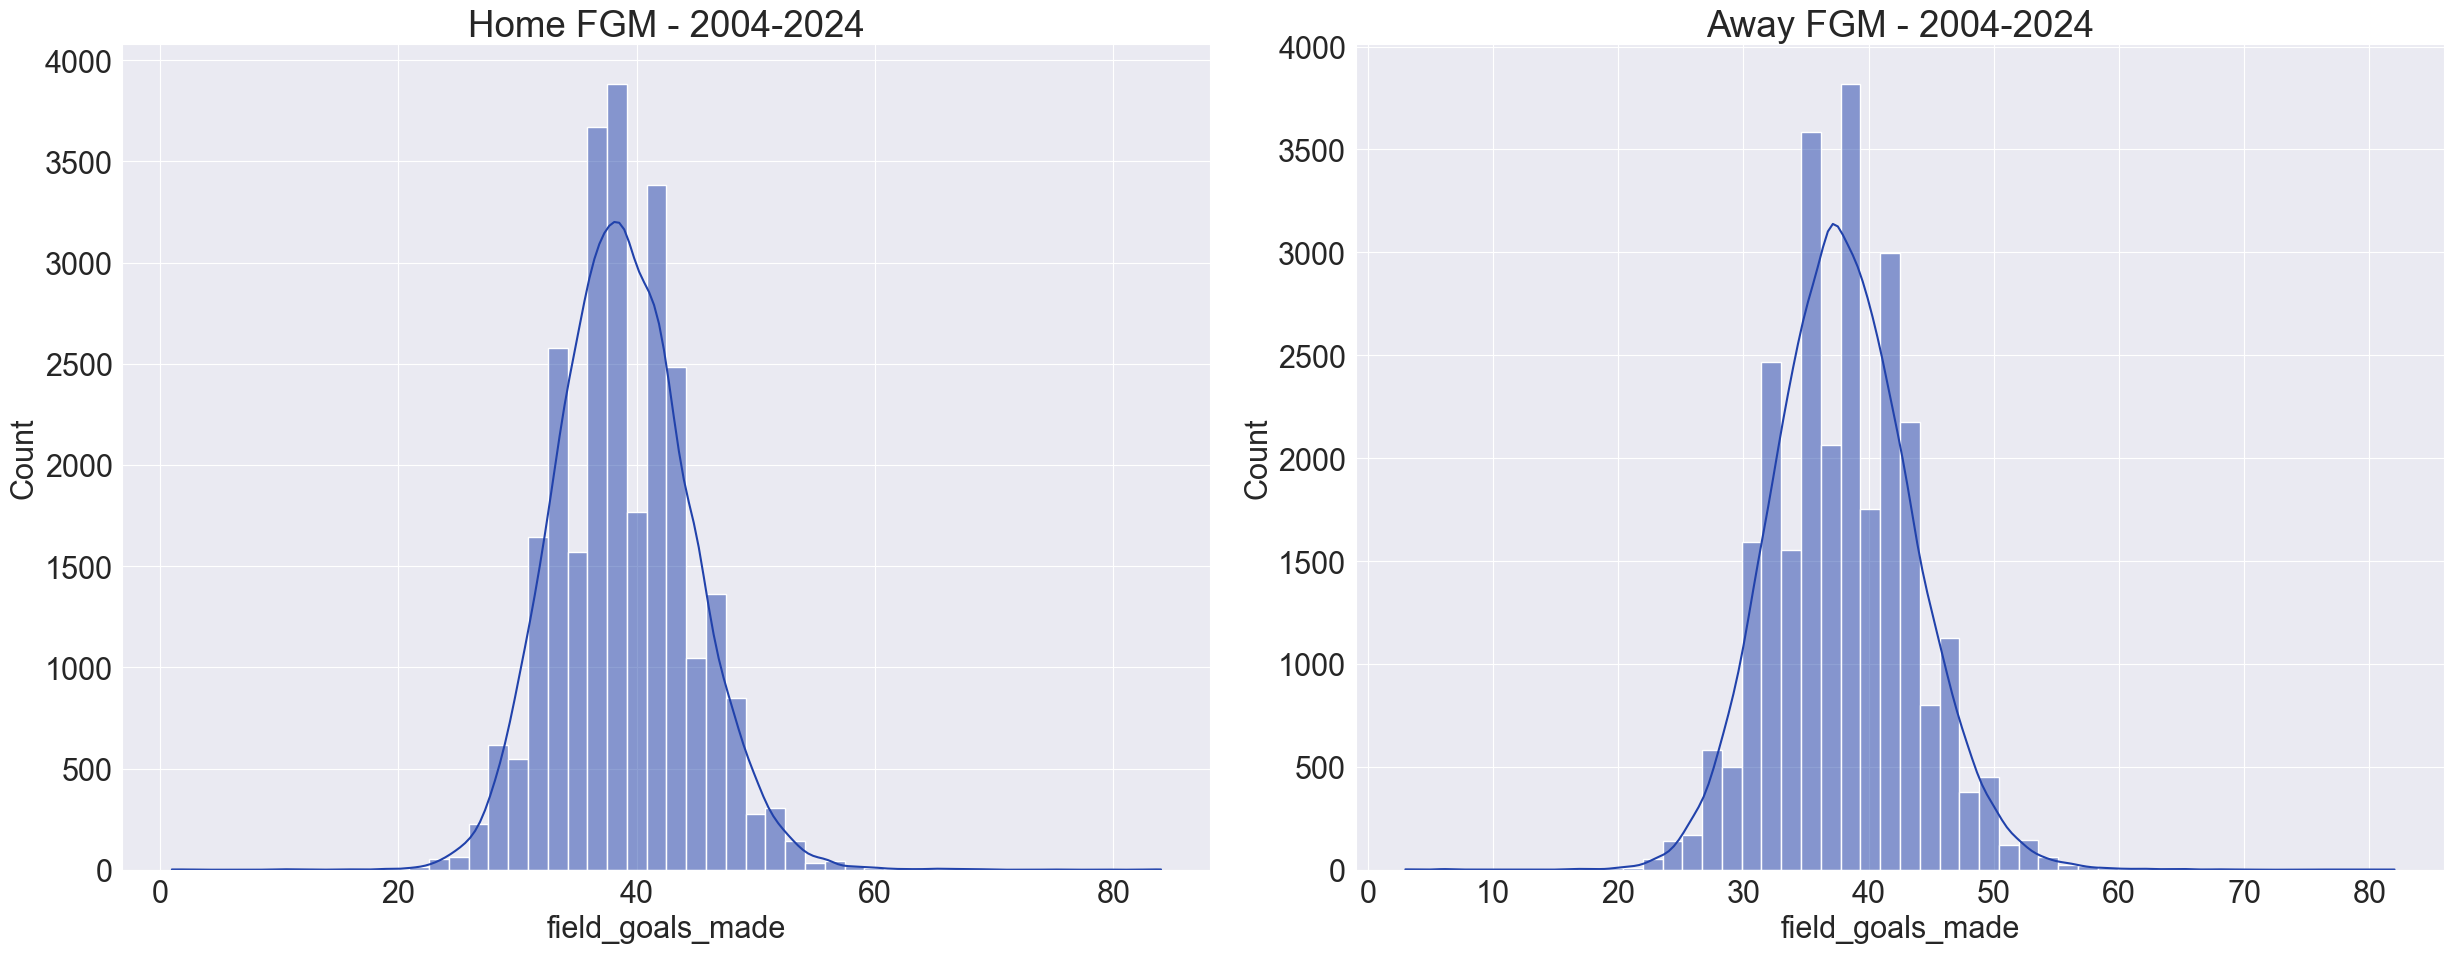

In [58]:
side_by_side_hists(l_fgm, ['Home FGM','Away FGM'])

In [61]:
run_ad_test(l_fgm)

Home Games:
  Test Statistic: 48.02421848780432,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 46.74626399531553,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



(AndersonResult(statistic=48.02421848780432, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=38.88602651244884, scale=5.579720795386814)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=46.74626399531553, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=37.97679221900935, scale=5.557913569351352)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

In [64]:
run_kw_test_on_home_vs_away(l_fgm)

Kruskal-Wallis Test Results:
  Test Statistic (H): 340.3631892124769
  p-value: 5.31832135544781e-76

Given a p-value of 5.31832135544781e-76 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.


KruskalResult(statistic=340.3631892124769, pvalue=5.31832135544781e-76)

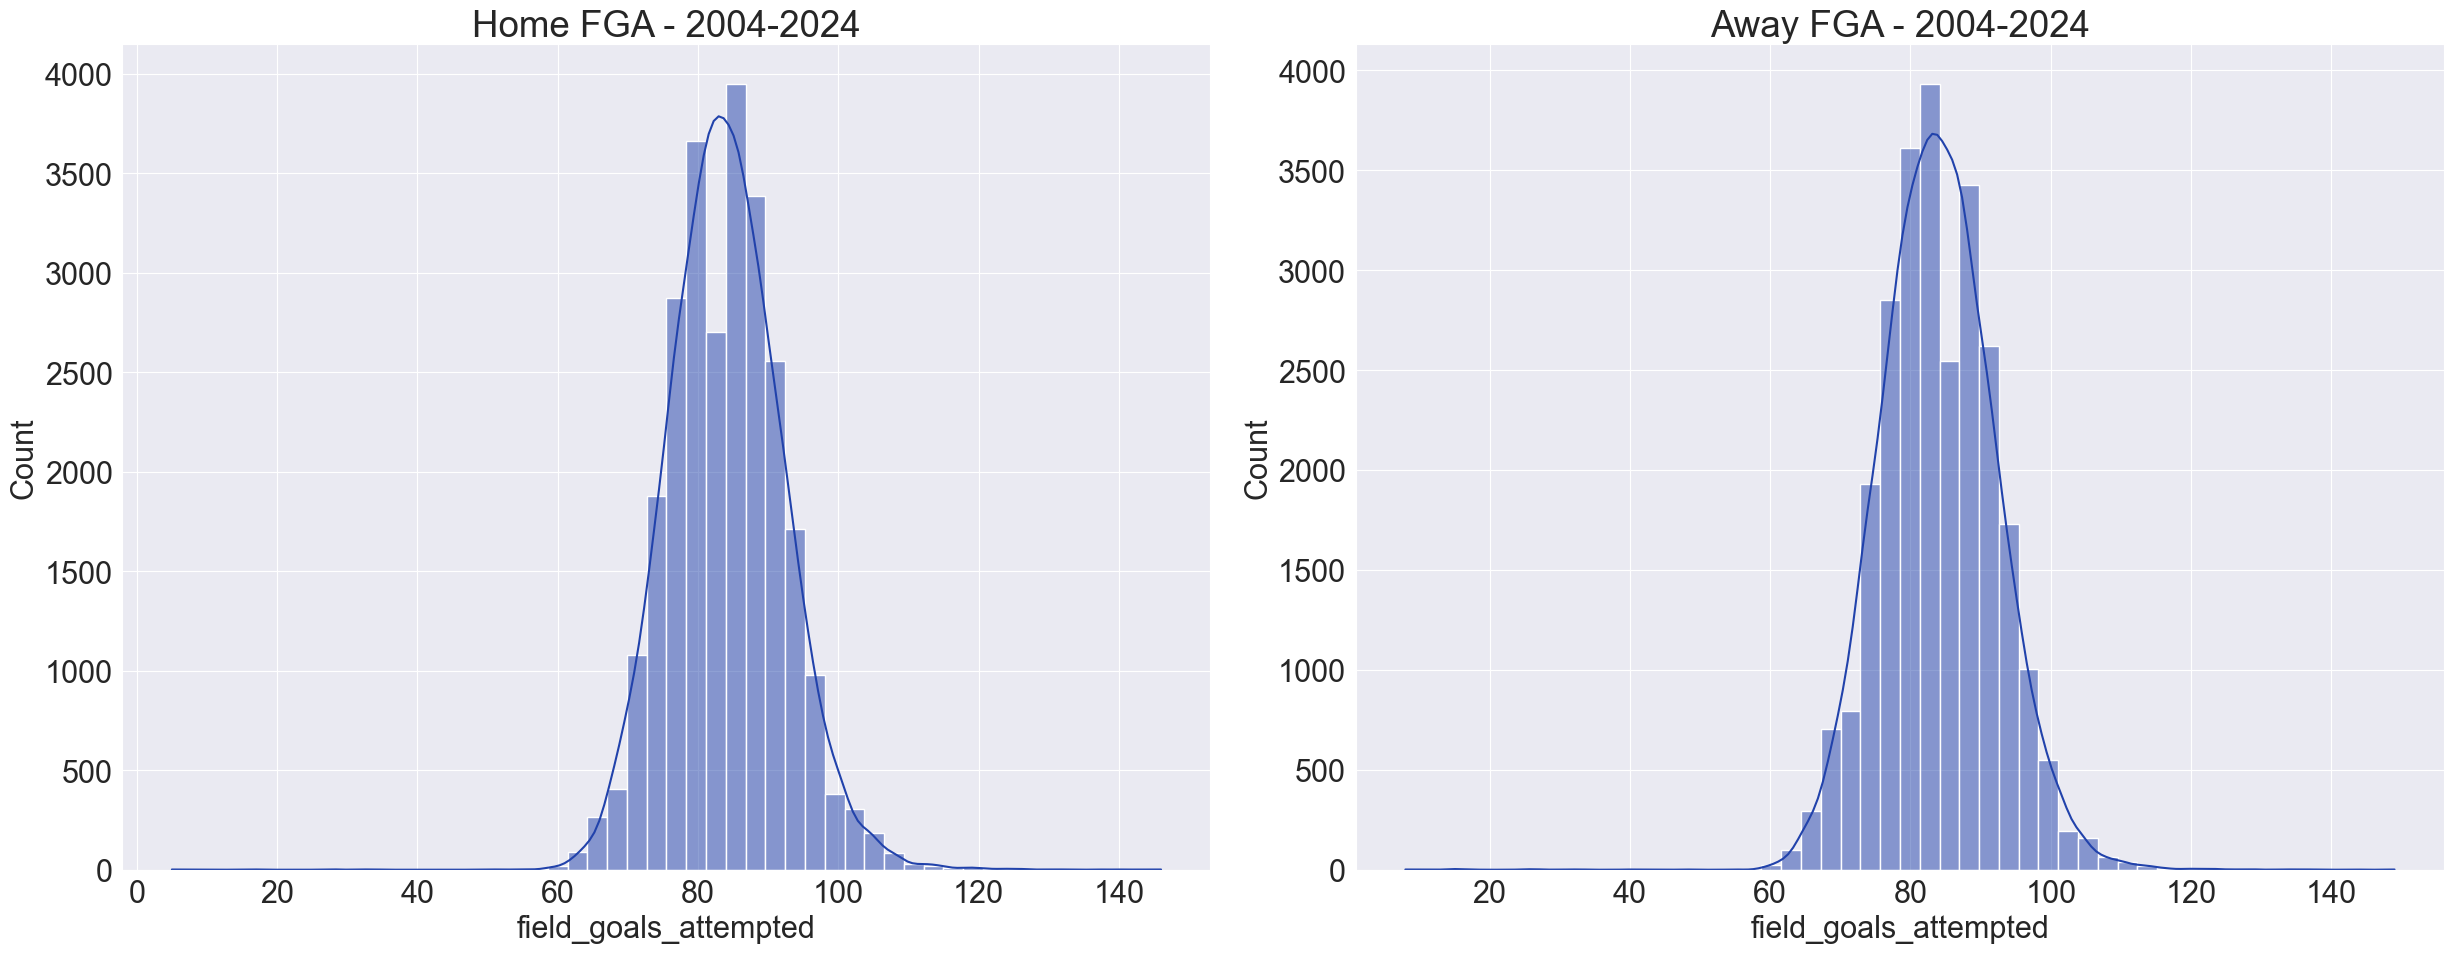

In [59]:
side_by_side_hists(l_fga, ['Home FGA','Away FGA'])

In [62]:
run_ad_test(l_fga)

Home Games:
  Test Statistic: 33.37135653198129,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 26.529695740253374,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



(AndersonResult(statistic=33.37135653198129, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=83.99297758083293, scale=8.16403134465998)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=26.529695740253374, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=83.96413684329114, scale=8.215739516051126)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

In [65]:
run_kw_test_on_home_vs_away(l_fga)

Kruskal-Wallis Test Results:
  Test Statistic (H): 0.01210587047650218
  p-value: 0.9123882151937658

Given a p-value of 0.9123882151937658 >= 0.05, we fail to reject the null hypothesis. Each group is likely to have the same mean.


KruskalResult(statistic=0.01210587047650218, pvalue=0.9123882151937658)

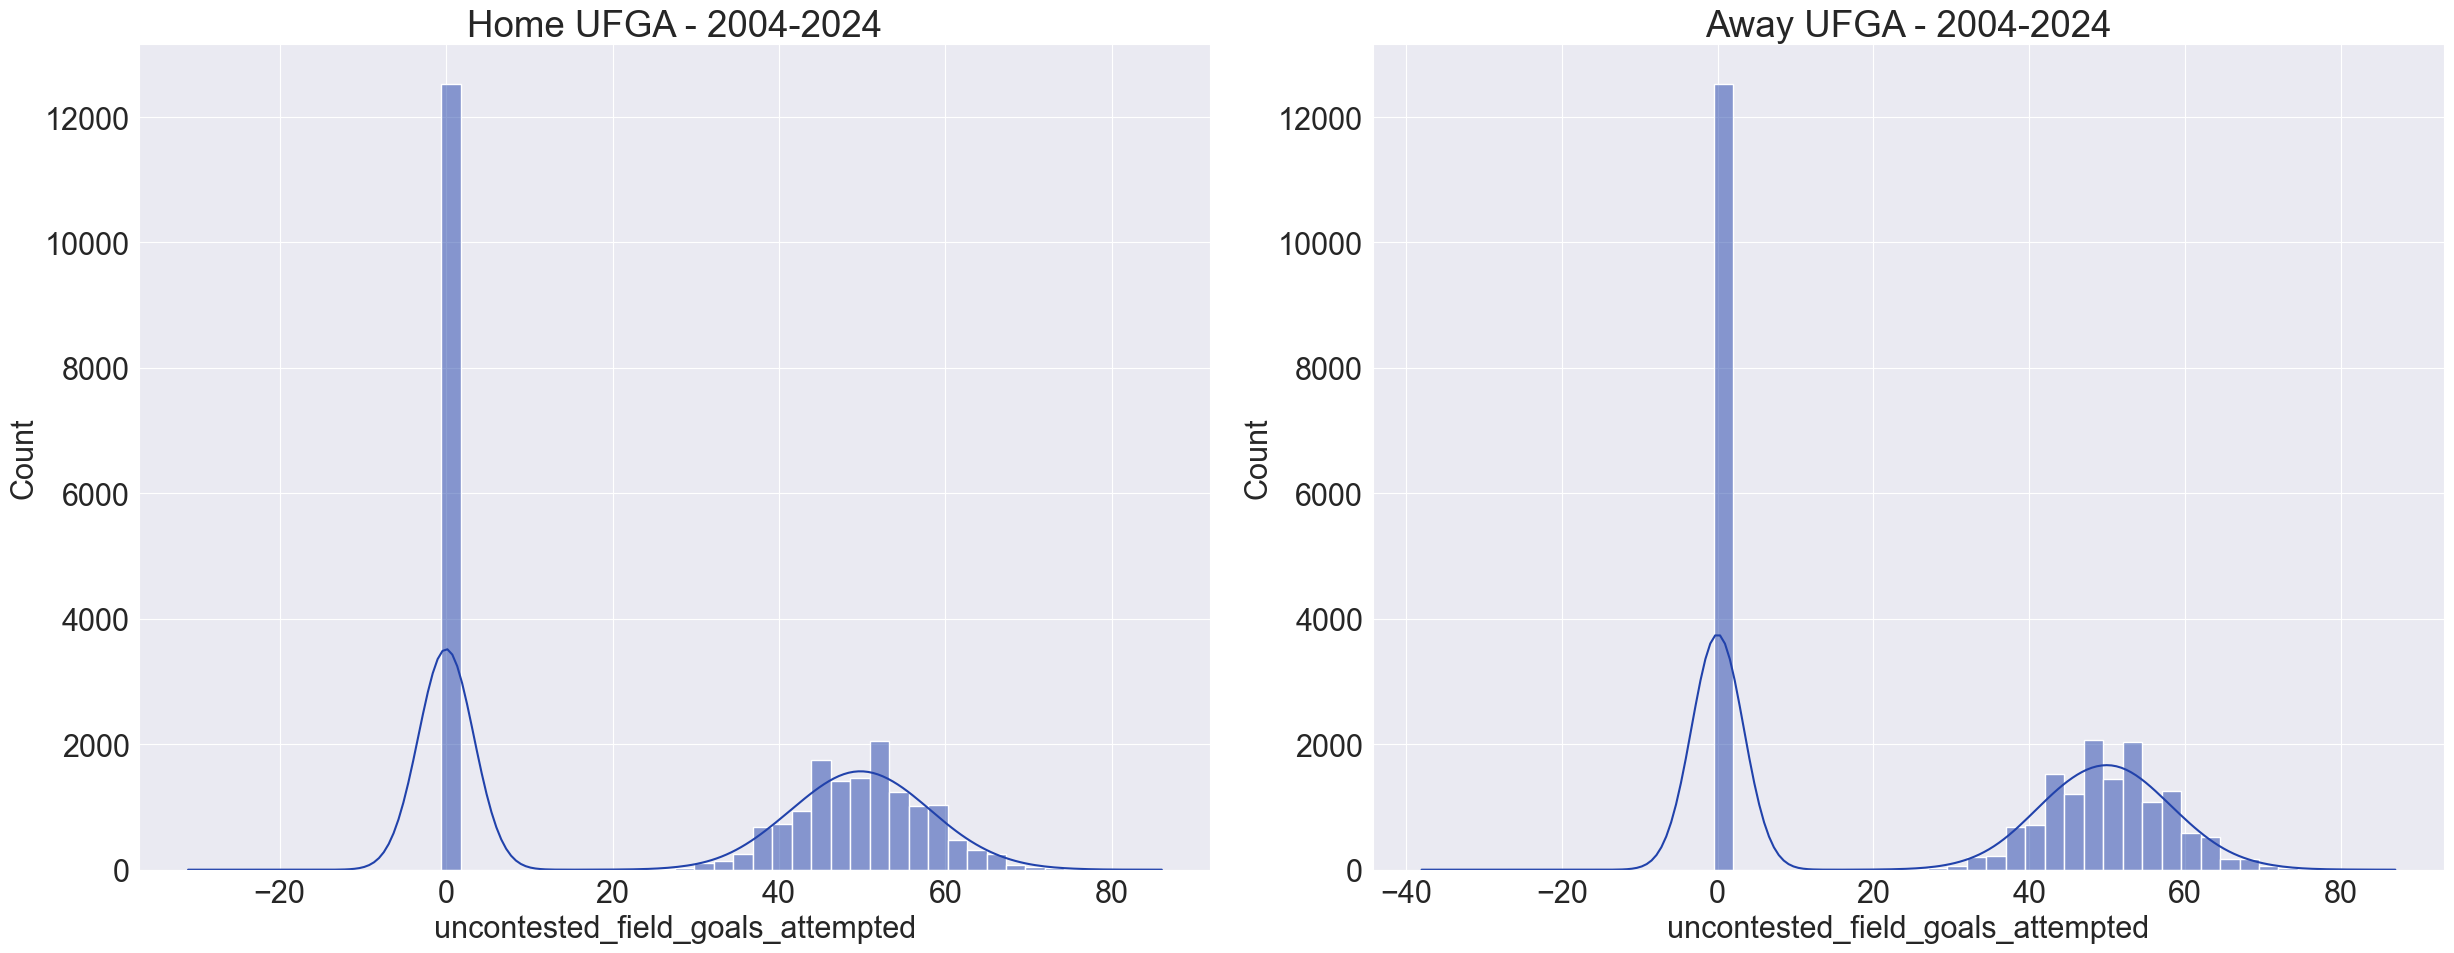

In [60]:
side_by_side_hists(l_ufga, ['Home UFGA','Away UFGA'])

In [63]:
run_ad_test(l_ufga)

Home Games:
  Test Statistic: 2954.071389010085,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 2951.6123723120727,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



(AndersonResult(statistic=2954.071389010085, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=26.399601937737053, scale=25.526396570579525)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=2951.6123723120727, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=26.443163468399113, scale=25.57151402291754)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

In [66]:
run_kw_test_on_home_vs_away(l_ufga)

Kruskal-Wallis Test Results:
  Test Statistic (H): 0.08917347459539215
  p-value: 0.7652305527431774

Given a p-value of 0.7652305527431774 >= 0.05, we fail to reject the null hypothesis. Each group is likely to have the same mean.


KruskalResult(statistic=0.08917347459539215, pvalue=0.7652305527431774)

Now we can construct the Histograms, KDE's, and QQ Plots for each feature. We will store the results in a list and construct a dataframe with them later.

#### 4.a.i. Field Goal Percentage

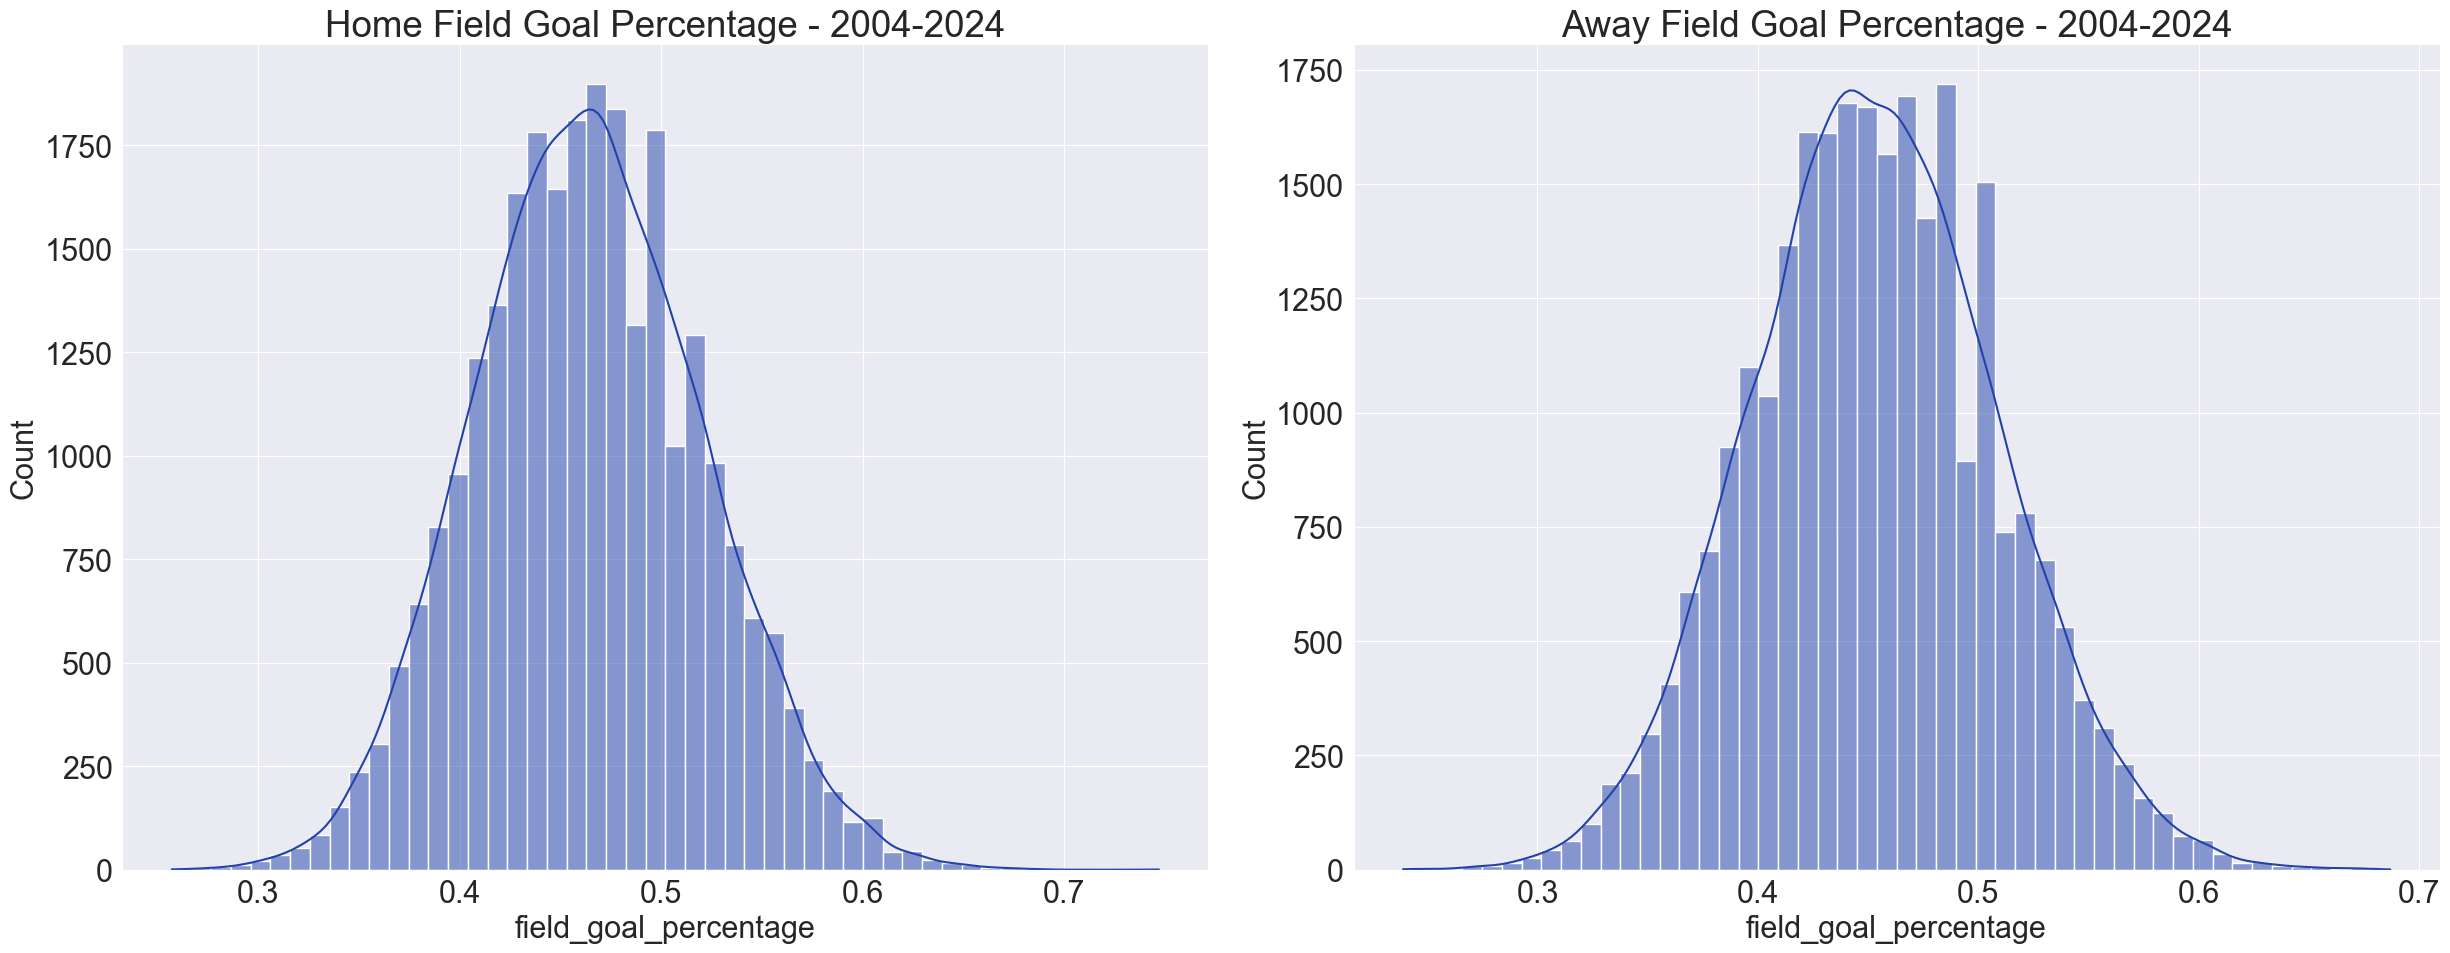

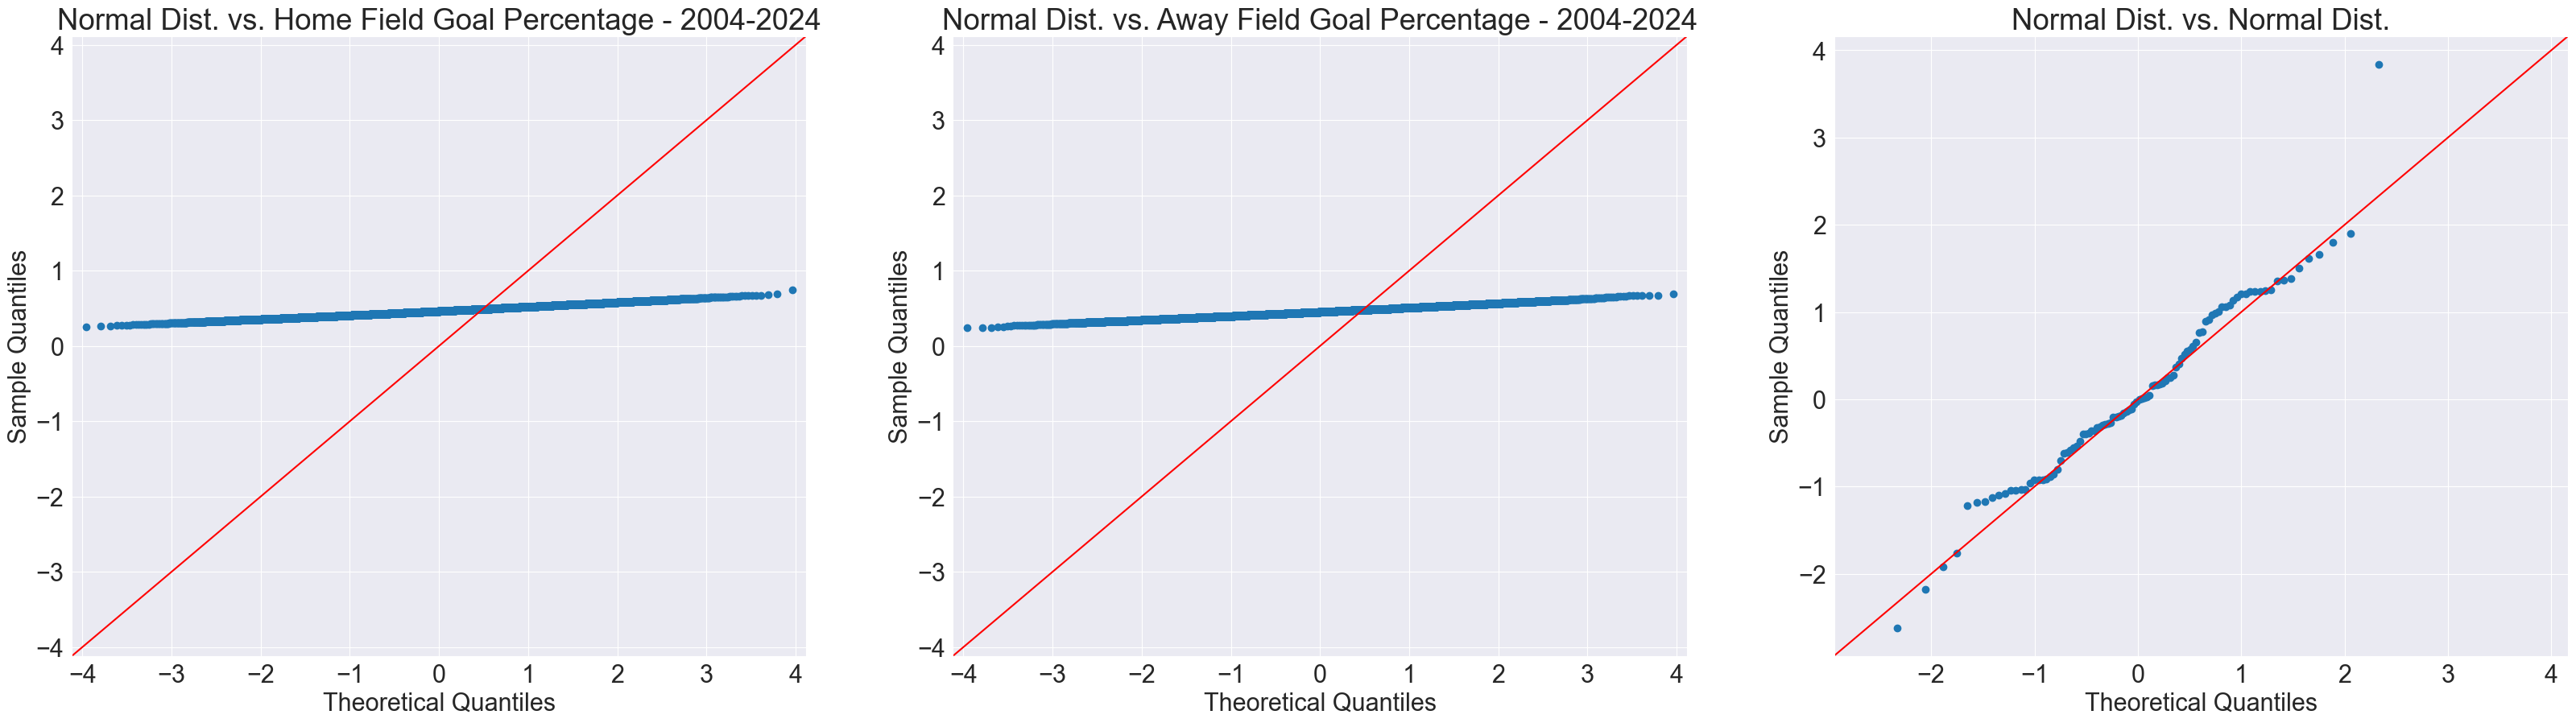

In [28]:
side_by_side_hists(l_fg, ['Home Field Goal Percentage', 'Away Field Goal Percentage'])
side_by_side_qq_plots(l_fg, ['Home Field Goal Percentage', 'Away Field Goal Percentage'])

From the Histograms, we see normal-ish distributions of field goal percentages. However after examining the QQ plots, the distributions do not align with a normal distribution at all.

In [29]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_fg)
print('\033[1mAnderson-Darling:')
run_ad_test(l_fg)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.9989653458657612,
  p-value: 8.095309809781149e-12

Away Games:
  Test Stat (W): 0.9994309714366256,
  p-value: 1.713423470847111e-07

Anderson-Darling:
Home Games:
  Test Statistic: 7.121832720844395,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 3.7647044355471735,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=7.121832720844395, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4638602651244883, scale=0.05650308870179072)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=3.7647044355471735, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4530448007811034, scale=0.05554630344472346)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

The Shapiro-Wilks and Anderson-Darling tests also confirm this. For Home Games we reject the Null Hypothesis for both the Shapiro-Wilks and the Anderson-Darling Tests, and we reject the Null Hypotheses for Away Games too. **This means neither home nor away games are normally distributed, and non-parametric hypothesis tests must be used.**

Because we have so many features to get through, the following sections will simply say if data looks normally distributed, and whether we accept/reject the null of each test.

#### 4.a.ii. Three Pointer Percentage

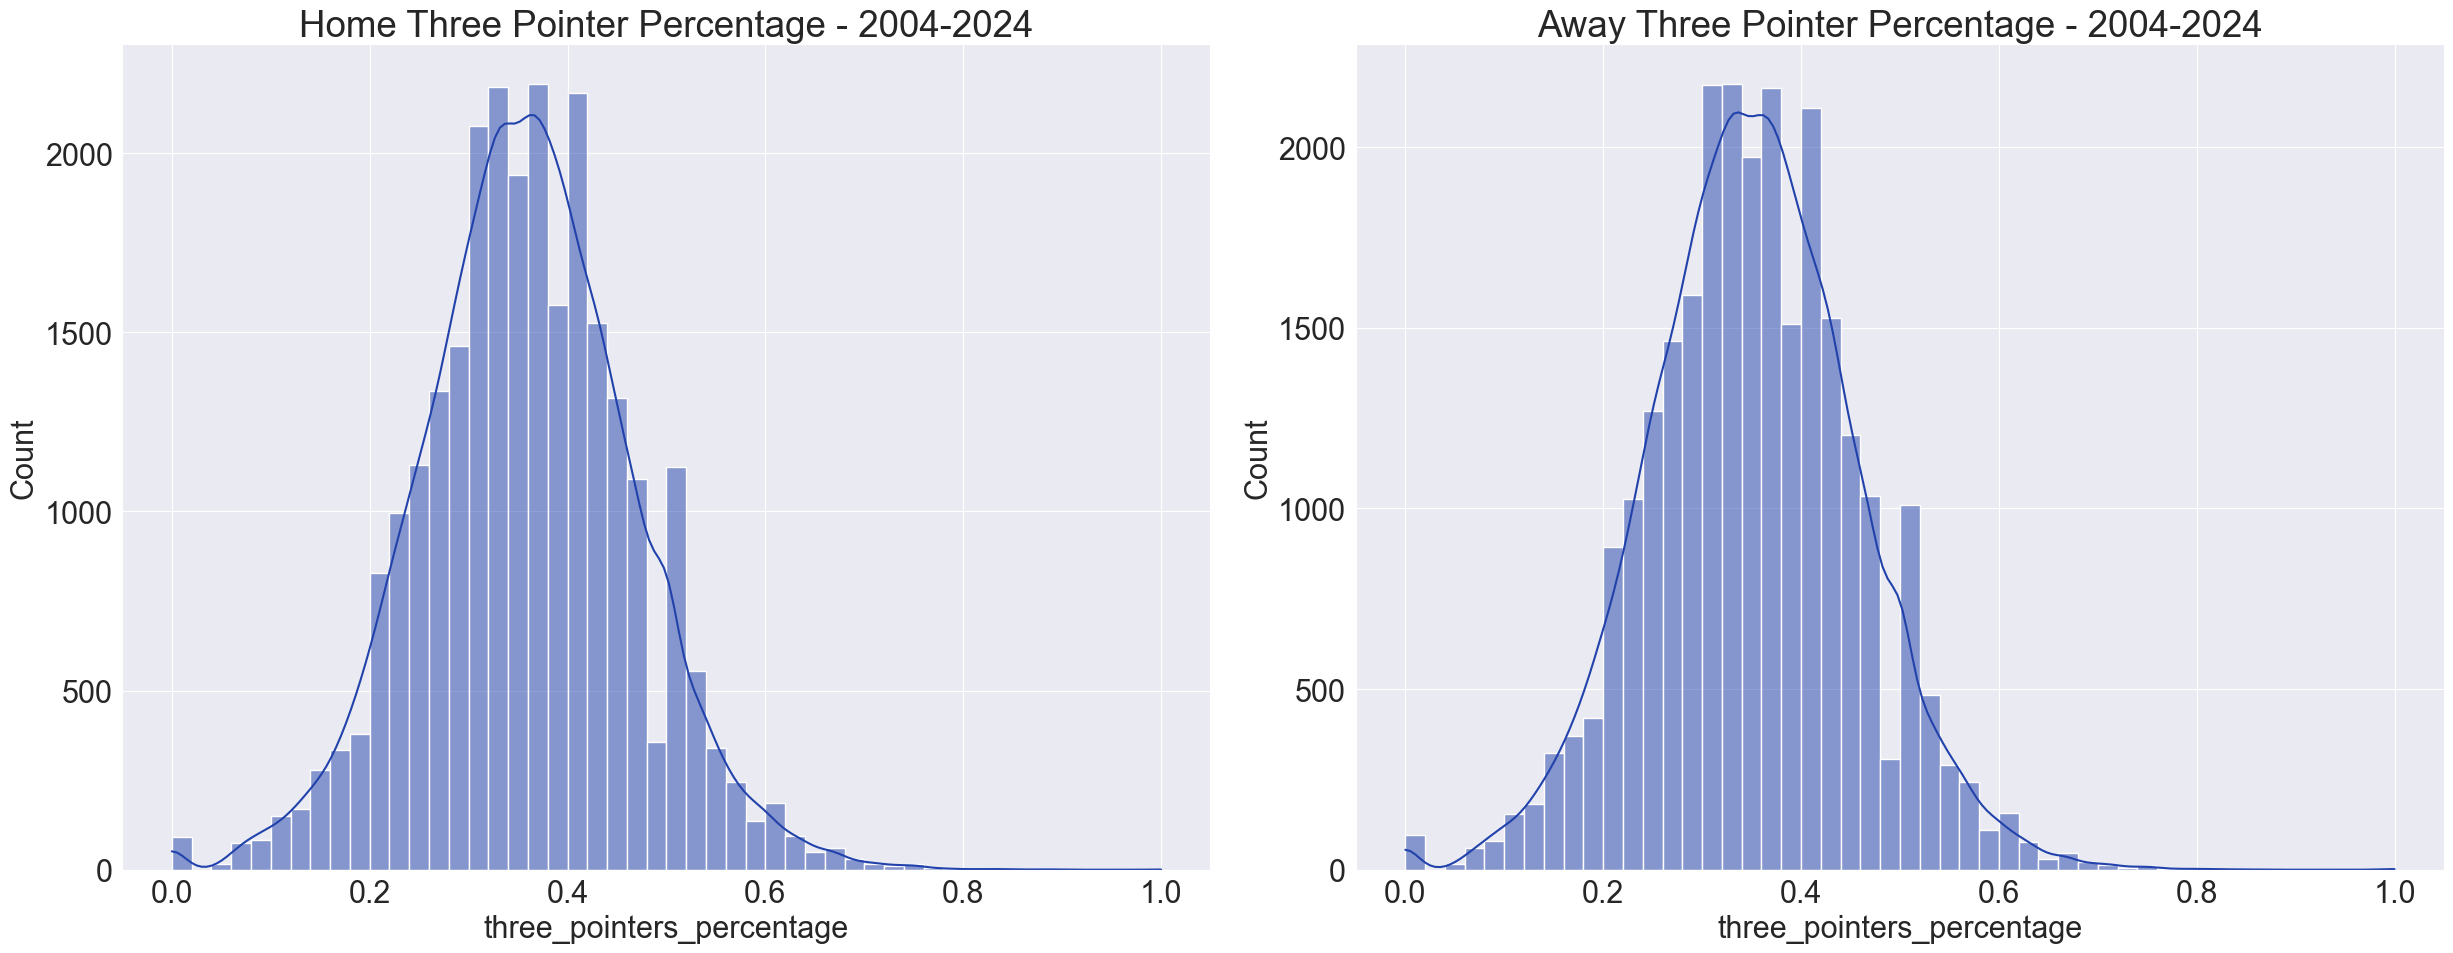

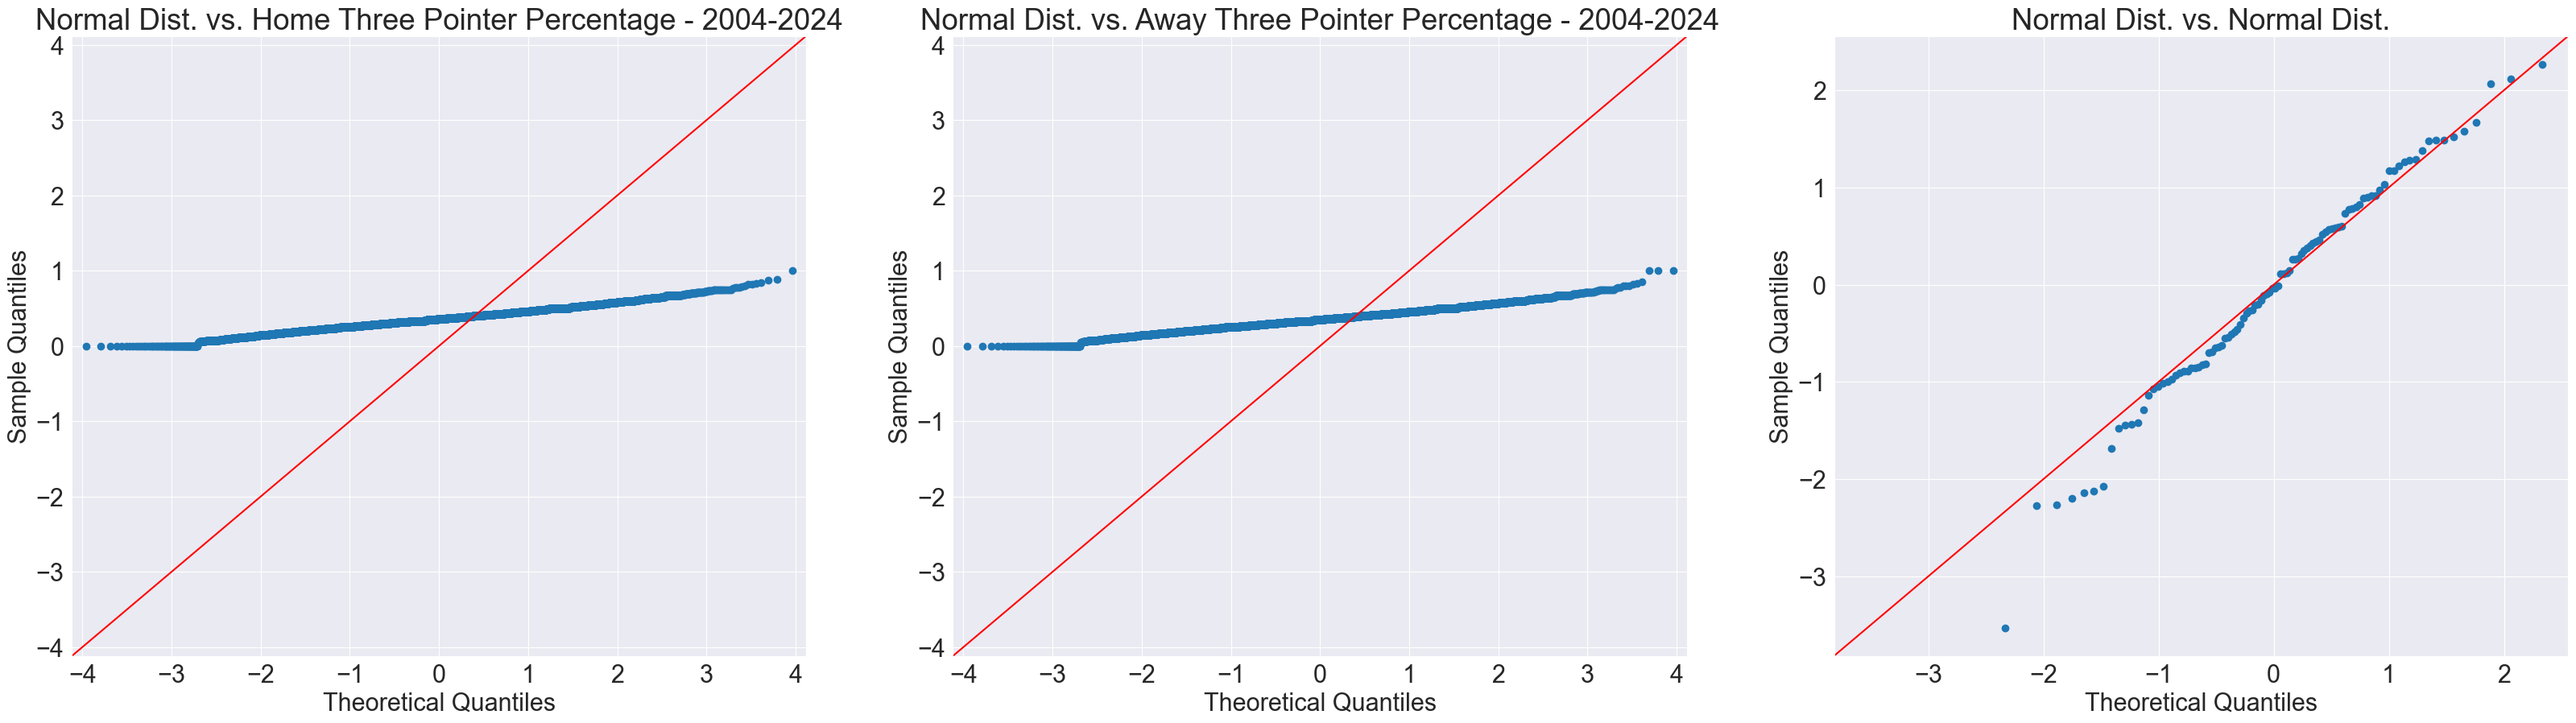

In [30]:
side_by_side_hists(l_tp, ['Home Three Pointer Percentage','Away Three Pointer Percentage'])
side_by_side_qq_plots(l_tp, ['Home Three Pointer Percentage','Away Three Pointer Percentage'])

**Histograms:** Appears Normal

**QQ Plots:** Appears Not Normal

In [31]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_tp)
print('\033[1mAnderson-Darling:')
run_ad_test(l_tp)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.9966313487644632,
  p-value: 1.0131586117572681e-23

Away Games:
  Test Stat (W): 0.9965998569003717,
  p-value: 7.834583552792708e-24

Anderson-Darling:
Home Games:
  Test Statistic: 18.07788793684449,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 14.5249850589571,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=18.07788793684449, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.35806109880205794, scale=0.10740327185788018)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=14.5249850589571, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.35134807916181604, scale=0.1055857842865567)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

#### 4.a.iii. Free Throw Percentage

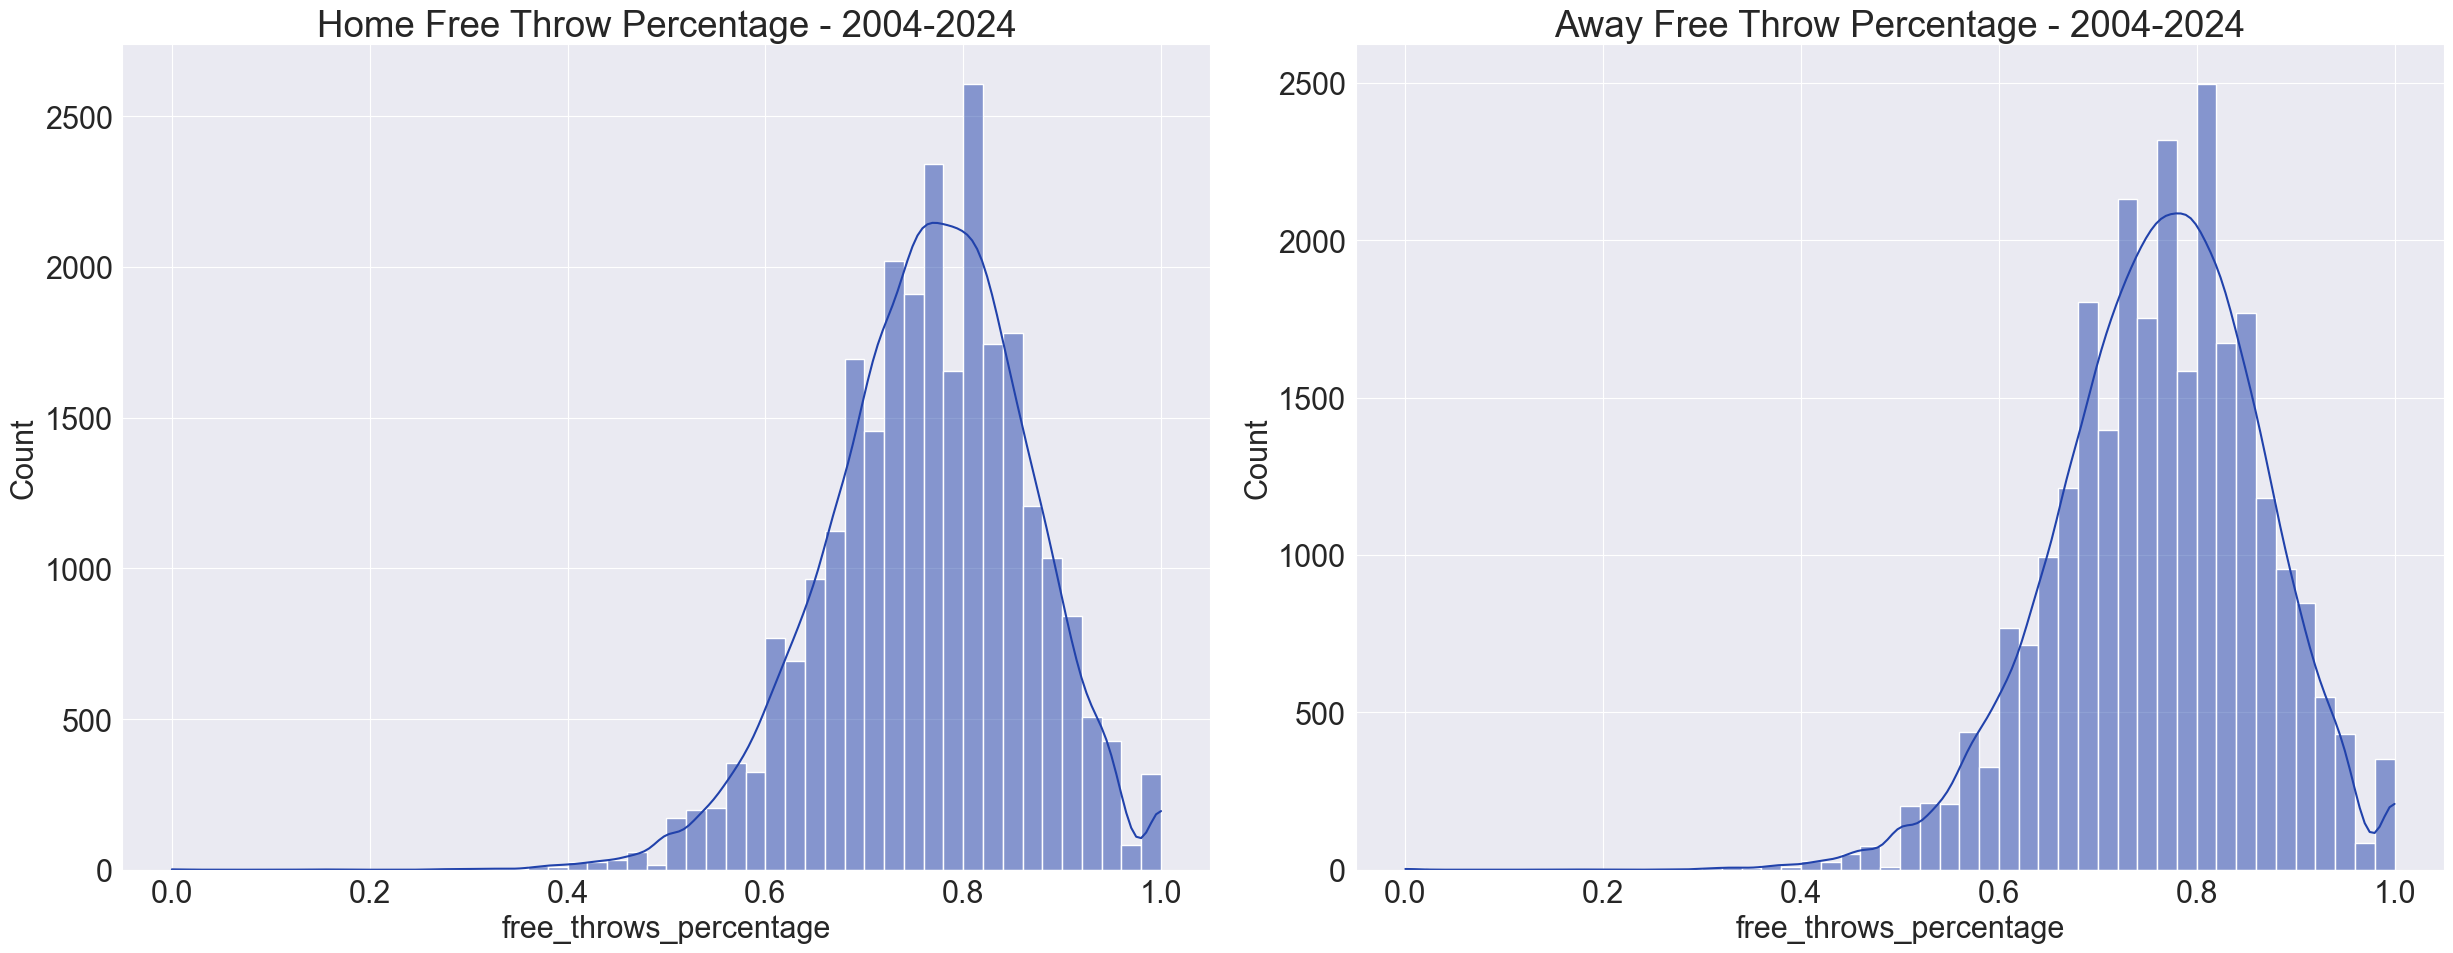

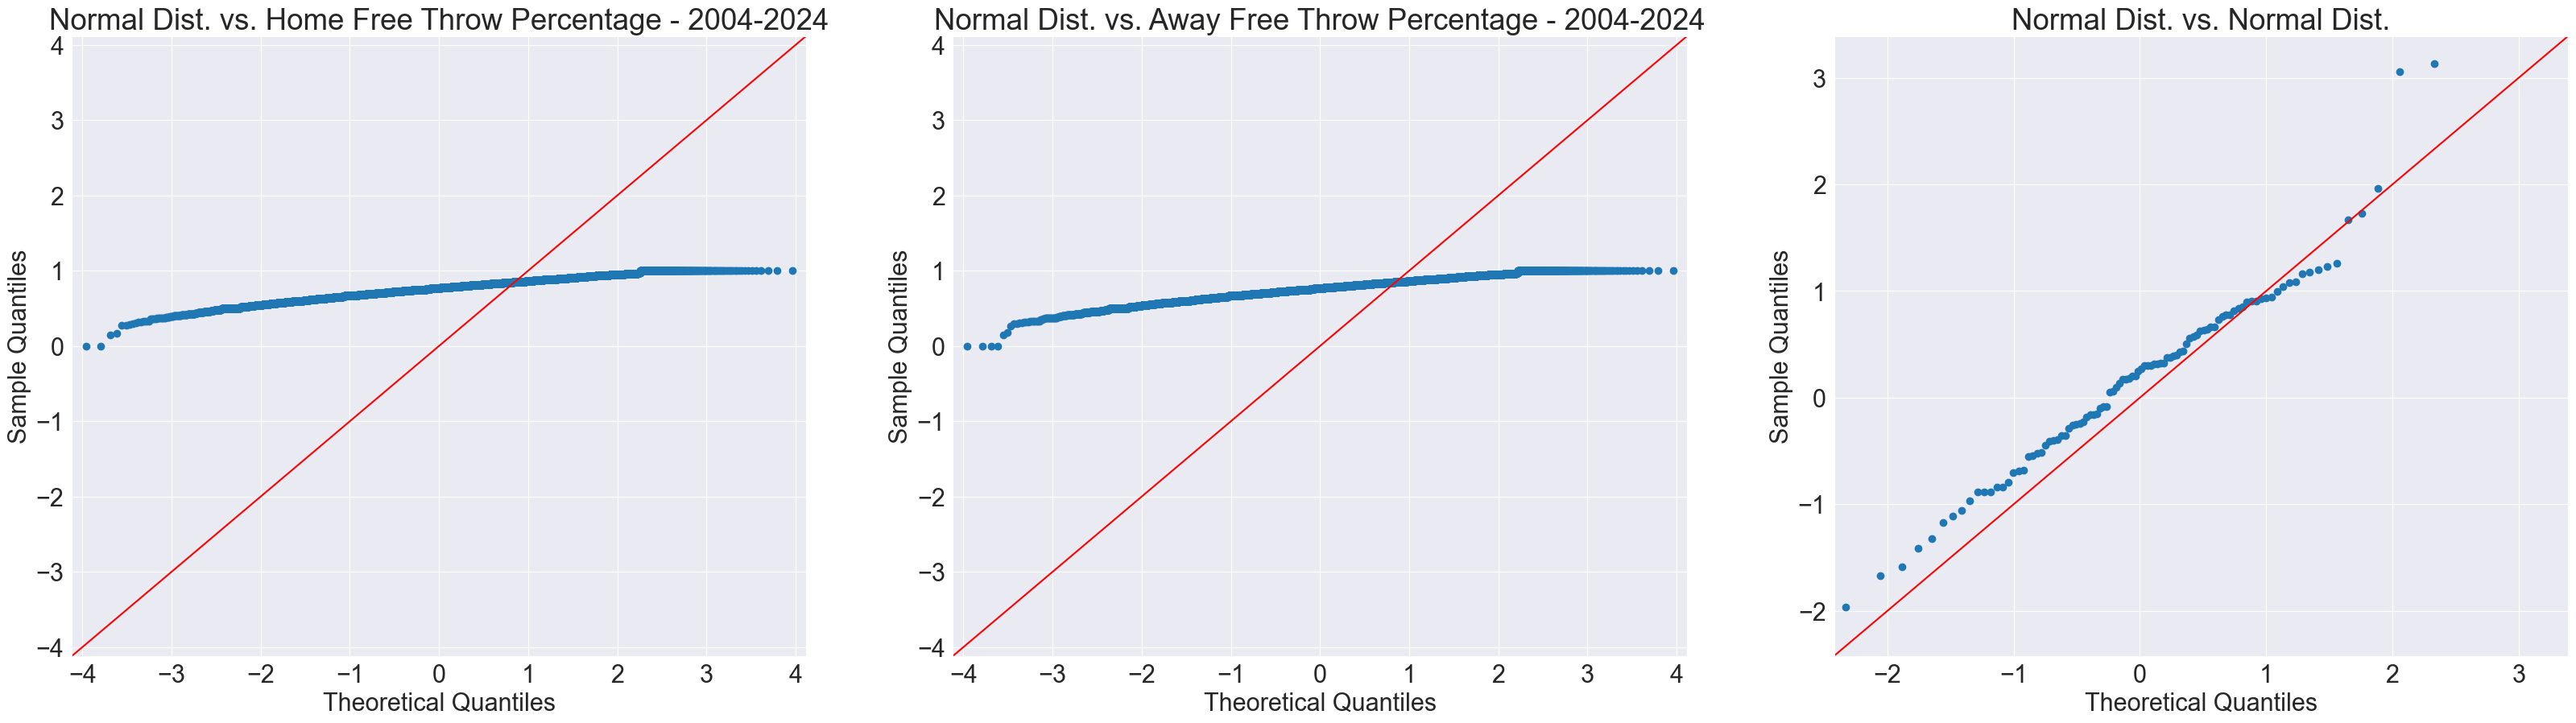

In [32]:
side_by_side_hists(l_ft, ['Home Free Throw Percentage','Away Free Throw Percentage'])
side_by_side_qq_plots(l_ft, ['Home Free Throw Percentage','Away Free Throw Percentage'])

**Histograms:** Appears Normal, but Skewed Right

**QQ Plots:** Appears Not Normal

In [33]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_ft)
print('\033[1mAnderson-Darling:')
run_ad_test(l_ft)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.9898241860928099,
  p-value: 6.013301081749145e-39

Away Games:
  Test Stat (W): 0.9888871700305055,
  p-value: 2.4862309854236295e-40

Anderson-Darling:
Home Games:
  Test Statistic: 40.930395791281626,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 39.00856756437861,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=40.930395791281626, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.7642655375718203, scale=0.10103718719376471)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=39.00856756437861, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.761456907882384, scale=0.10379947674751665)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

#### 4.a.iv. Offensive Rebound Percentage

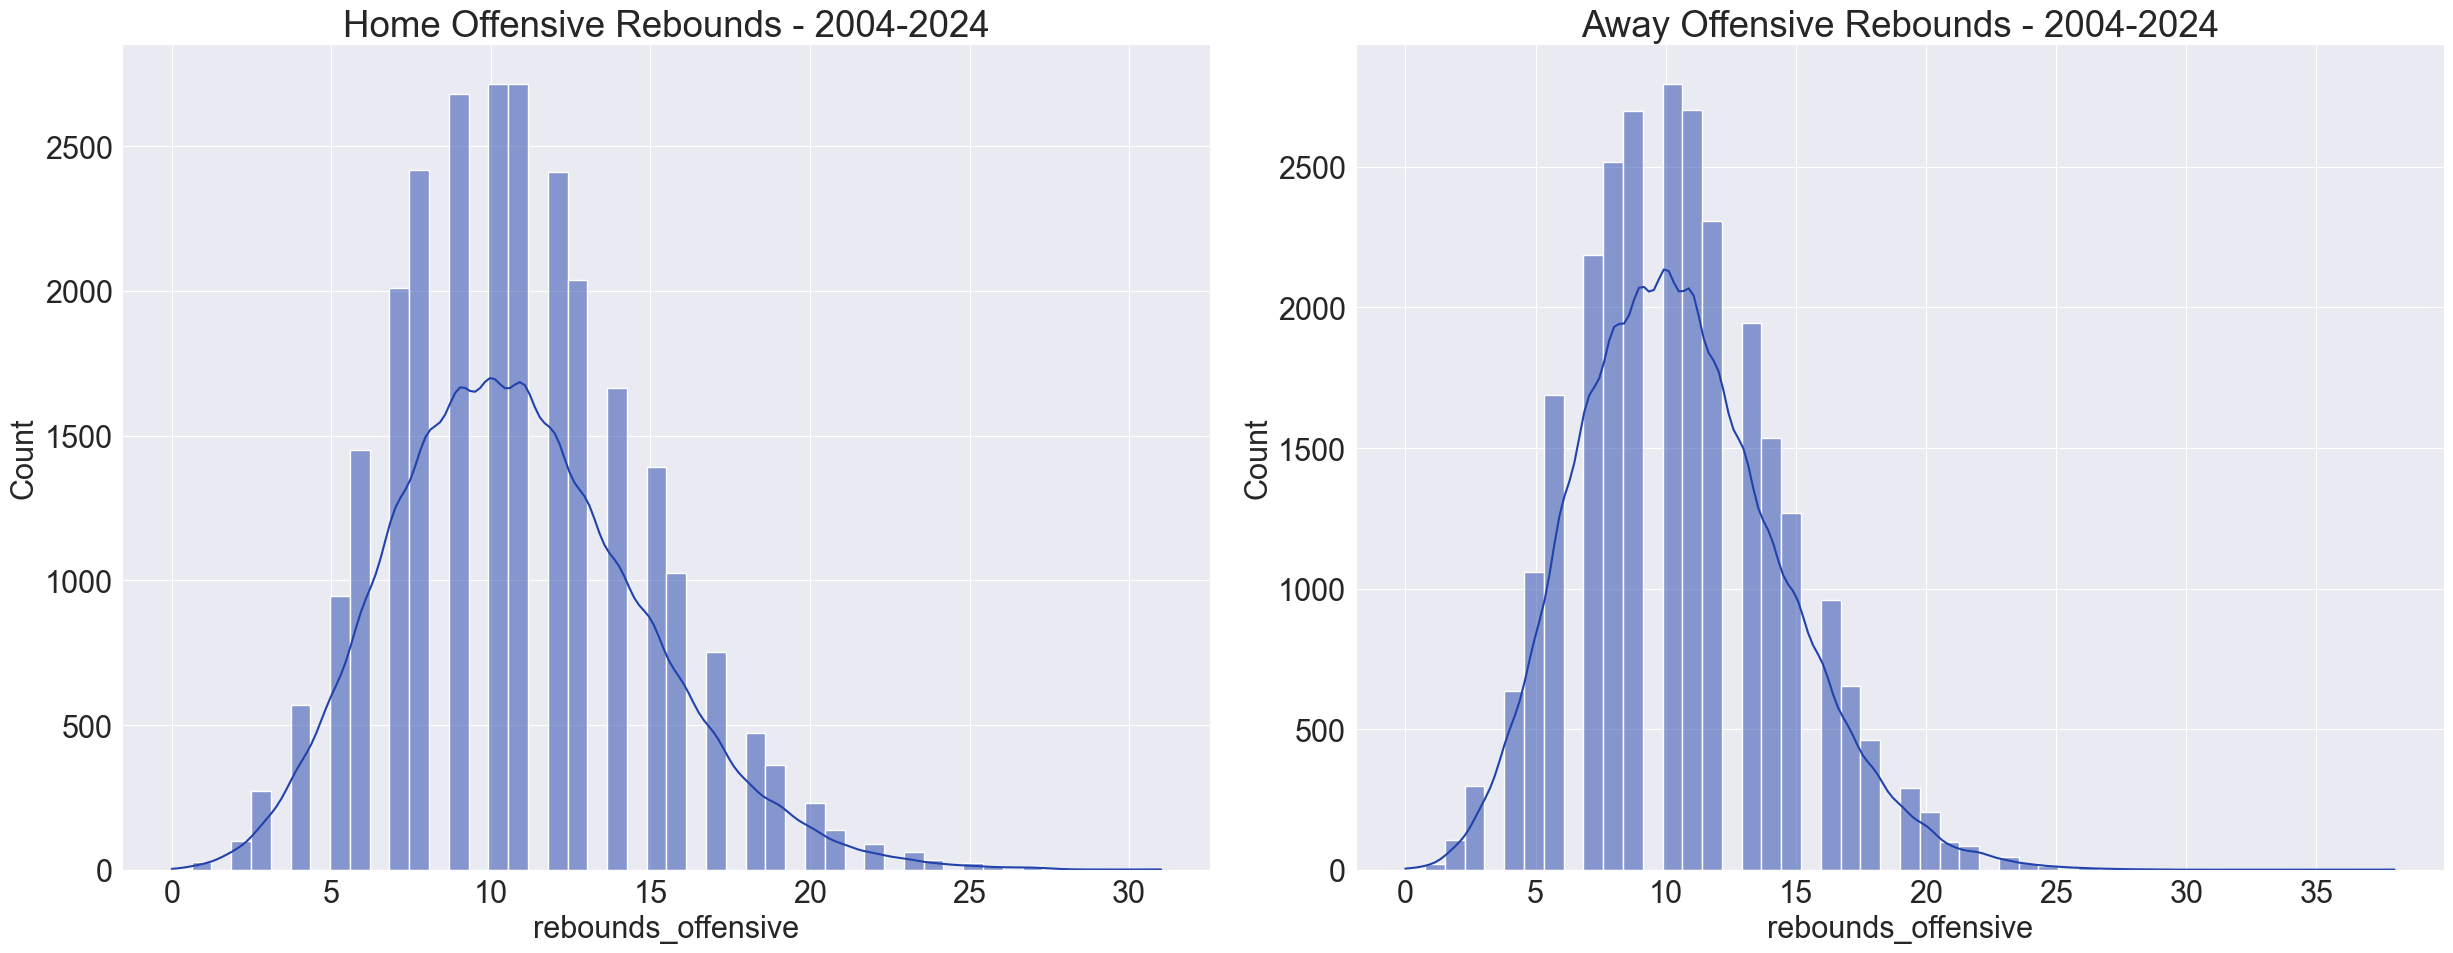

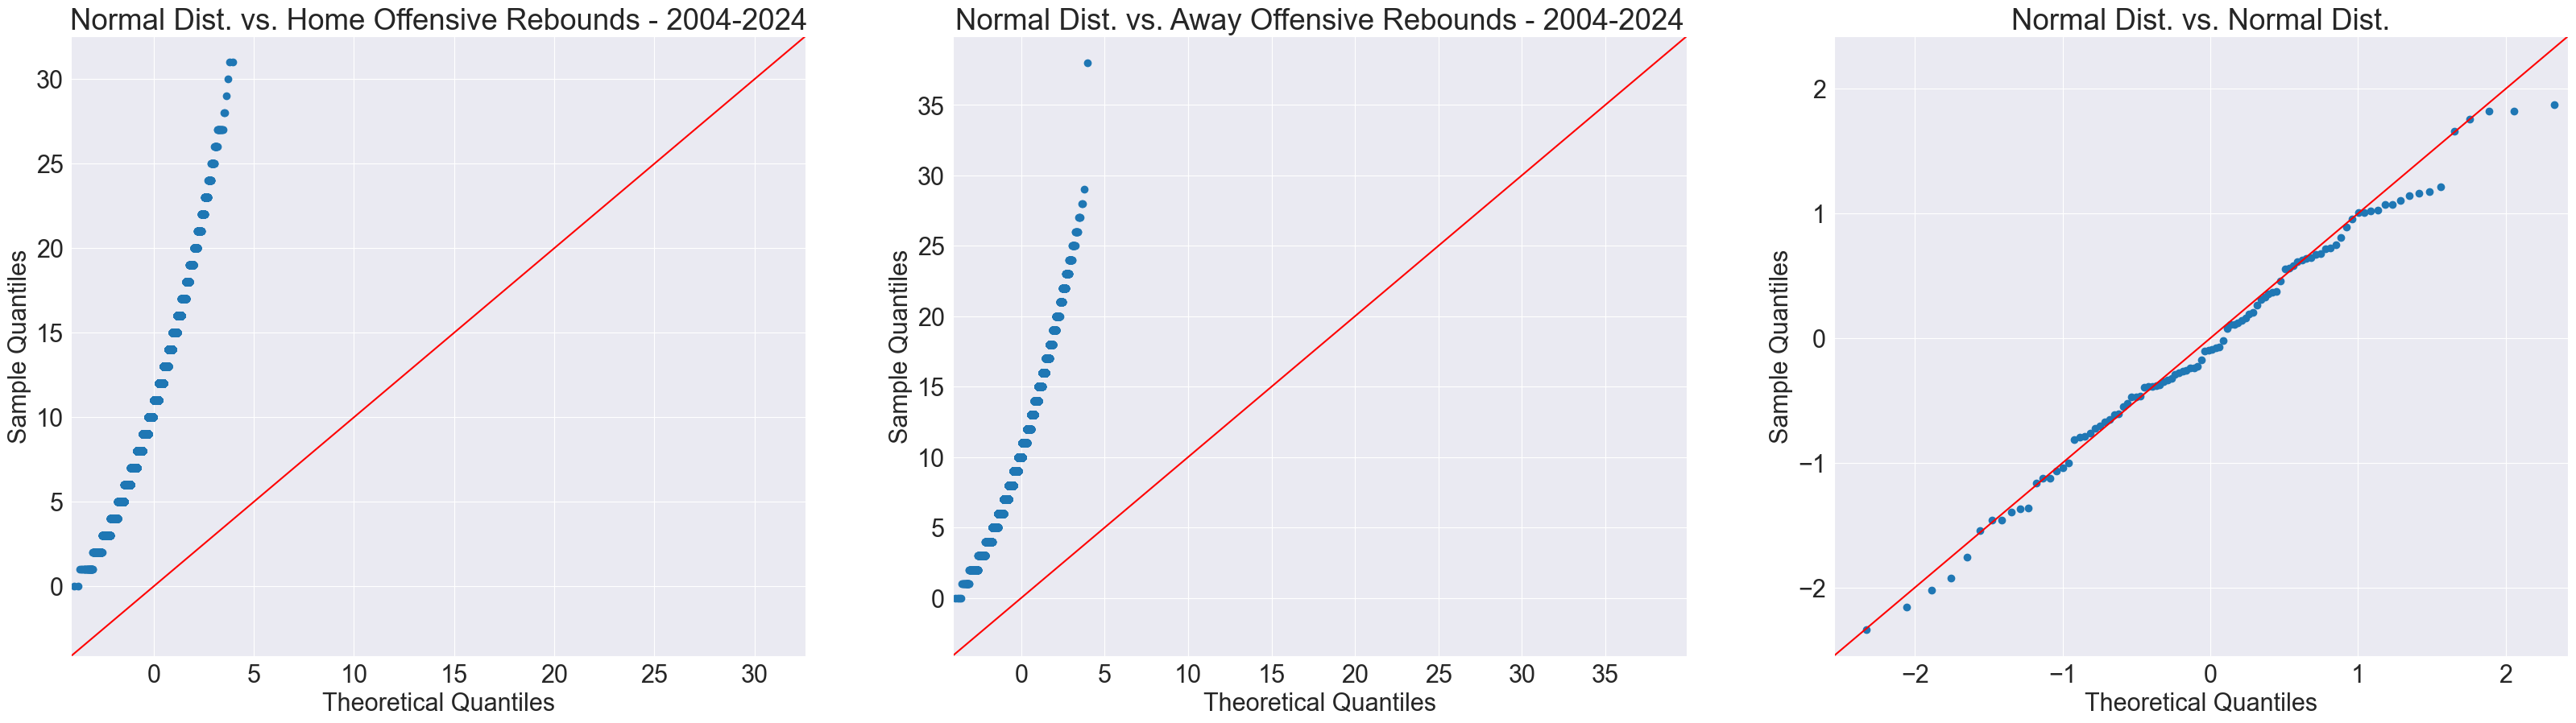

In [34]:
side_by_side_hists(l_r_off, ['Home Offensive Rebounds','Away Offensive Rebounds'])
side_by_side_qq_plots(l_r_off, ['Home Offensive Rebounds','Away Offensive Rebounds'])

**Histograms:** Appears Normal, But Skewed Slightly Left

**QQ Plots:** Appears Not Normal

In [35]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_r_off)
print('\033[1mAnderson-Darling:')
run_ad_test(l_r_off)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.9824440889170967,
  p-value: 6.431823514656249e-48

Away Games:
  Test Stat (W): 0.9815072125980359,
  p-value: 7.993993196137251e-49

Anderson-Darling:
Home Games:
  Test Statistic: 132.23631263887,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 141.45149311434943,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=132.23631263887, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=10.837357767847084, scale=3.9259644042452035)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=141.45149311434943, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=10.545908595891698, scale=3.85153892143113)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

#### 4.a.v. Defensive Rebounds Percentage

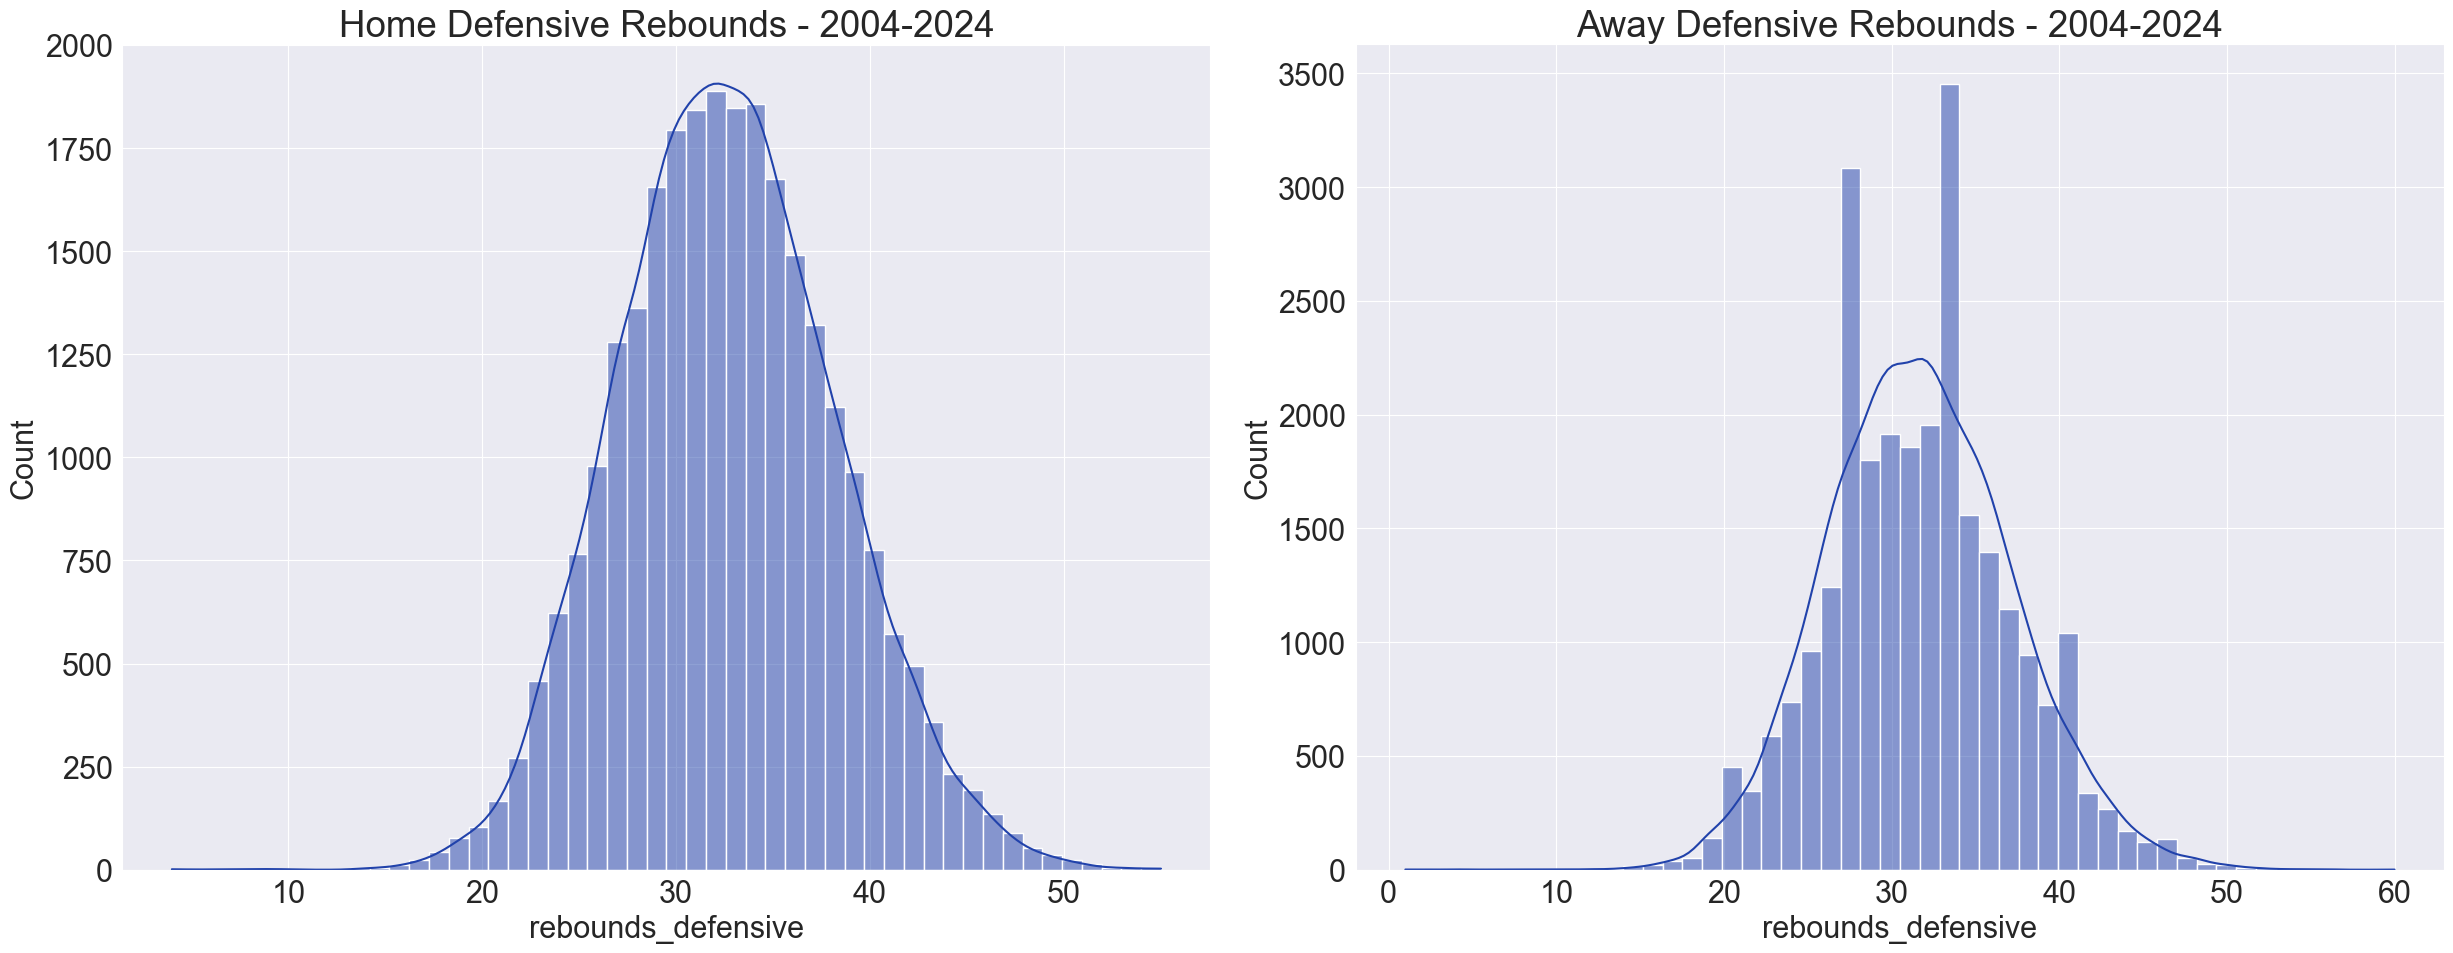

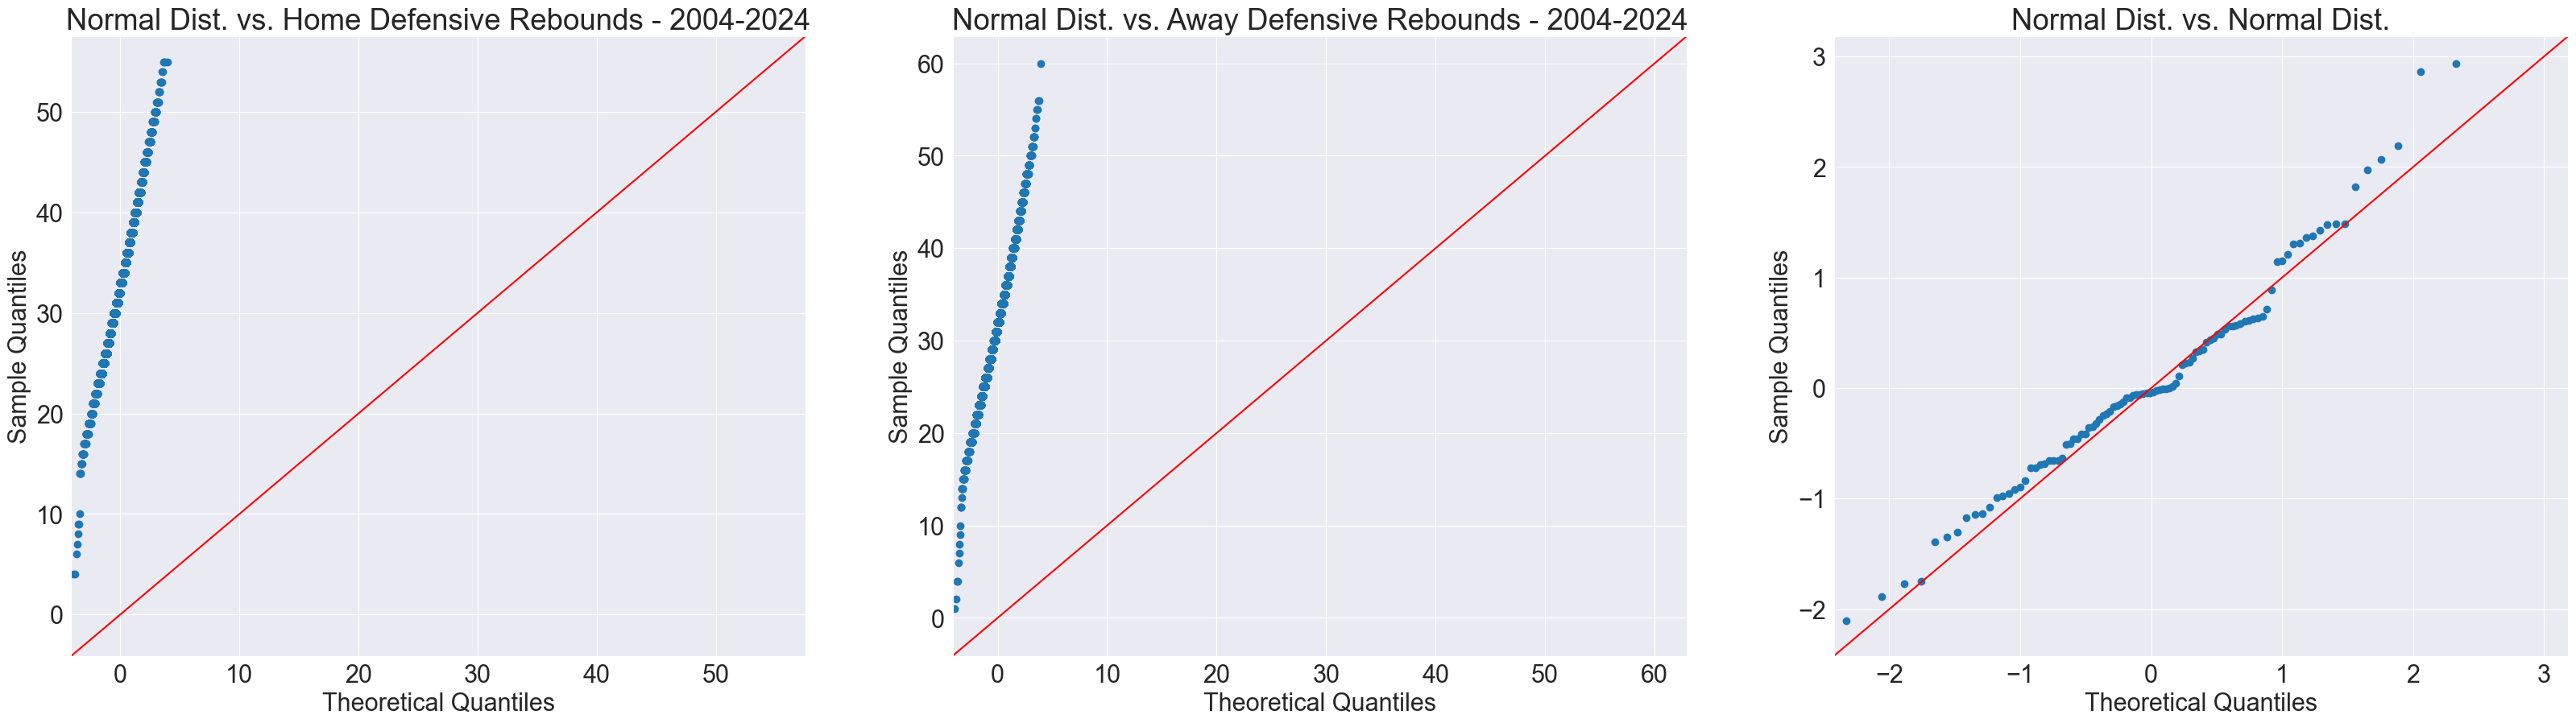

In [36]:
side_by_side_hists(l_r_def, ['Home Defensive Rebounds','Away Defensive Rebounds'])
side_by_side_qq_plots(l_r_def, ['Home Defensive Rebounds','Away Defensive Rebounds'])

**Histograms:** Home Appears Normal, Away Games Appears Not Normal

**QQ Plots:** Appears Not Normal

In [37]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_r_def)
print('\033[1mAnderson-Darling:')
run_ad_test(l_r_def)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.9955650146590685,
  p-value: 3.867516970325896e-27

Away Games:
  Test Stat (W): 0.9948811328470223,
  p-value: 5.104019143857576e-29

Anderson-Darling:
Home Games:
  Test Statistic: 43.8340341910116,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 46.08275975131619,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=43.8340341910116, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=32.638814825941644, scale=5.5835727944404185)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=46.08275975131619, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=31.685868789665403, scale=5.545147339930599)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

#### 4.a.vi. Contested Field Goal Percentage

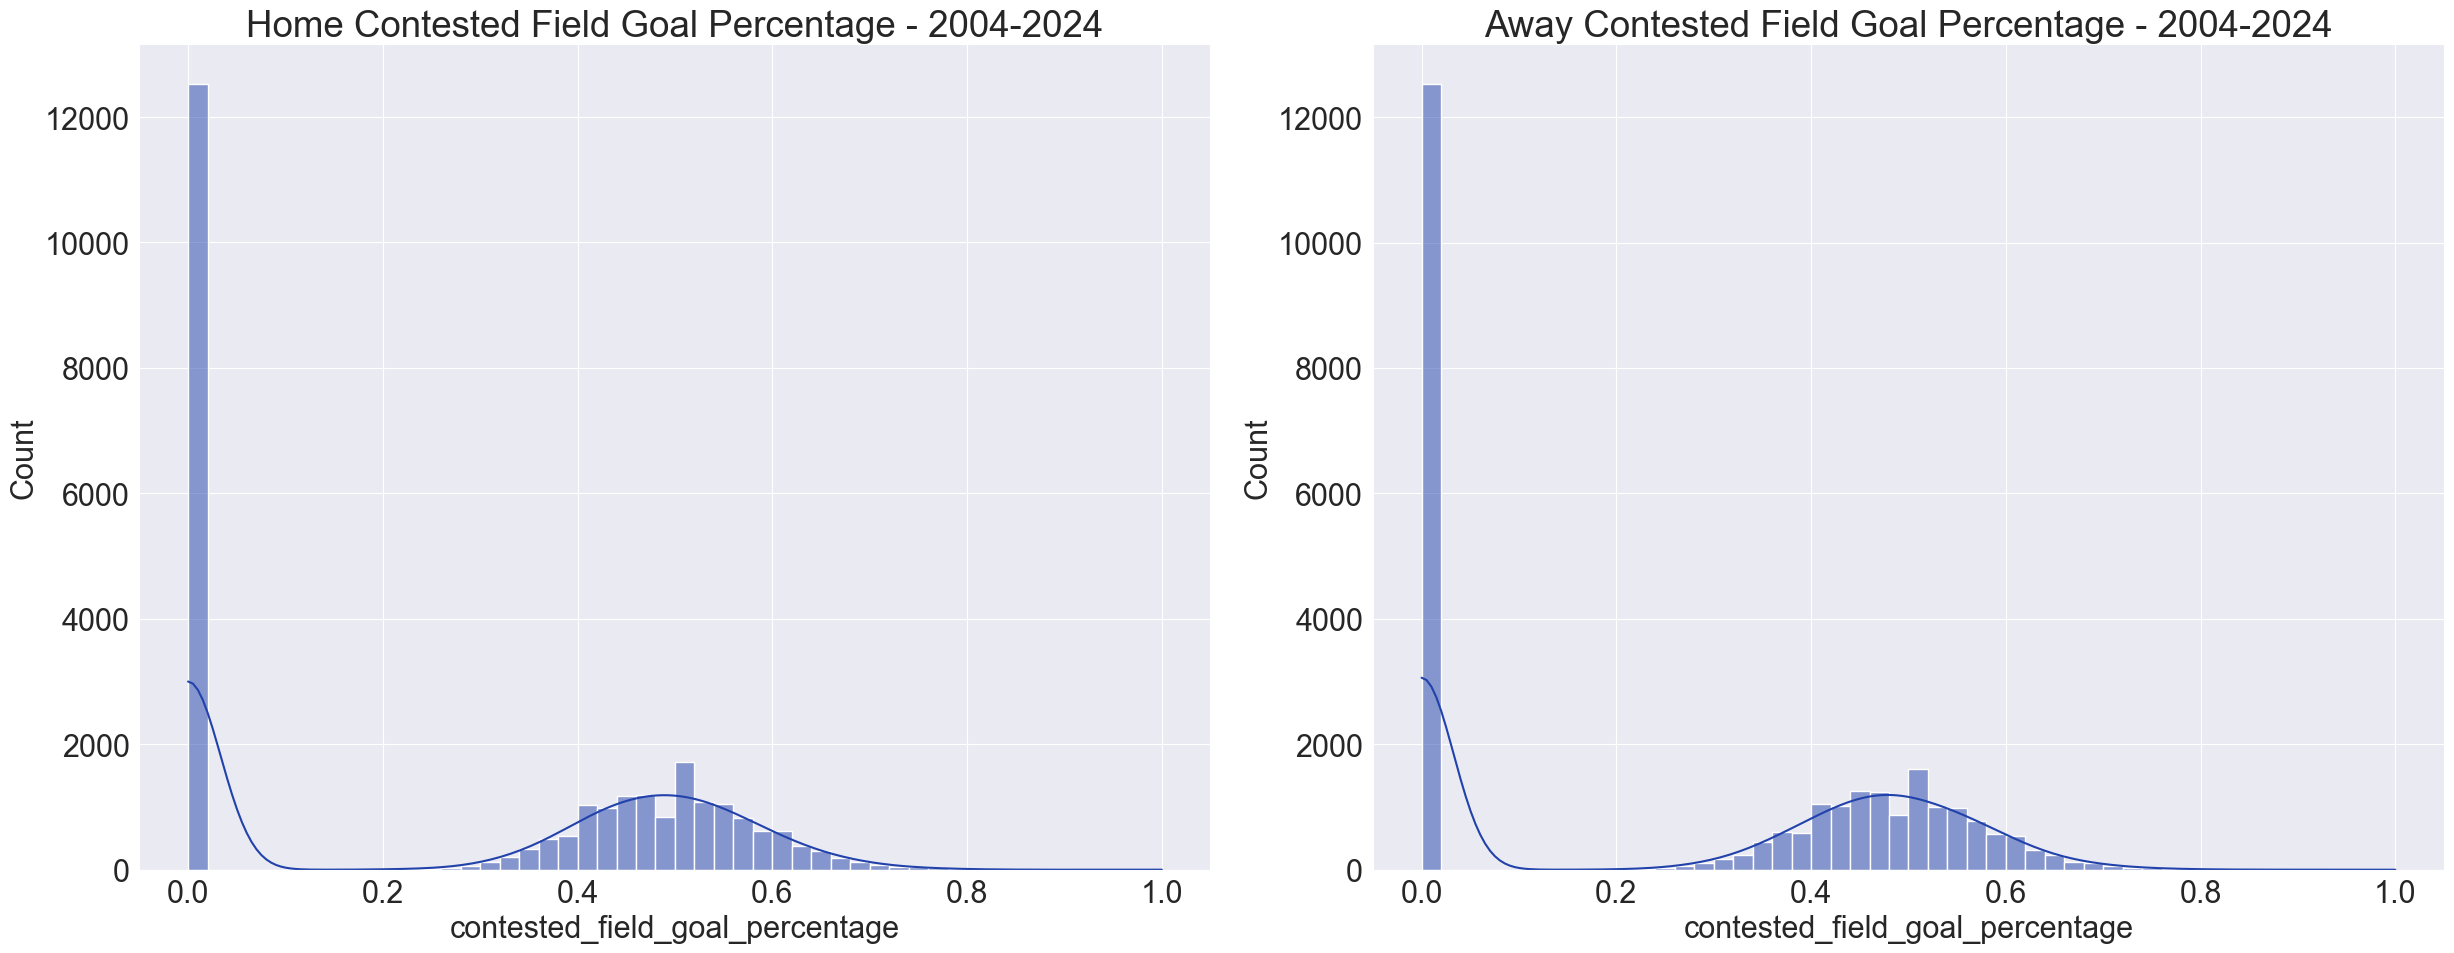

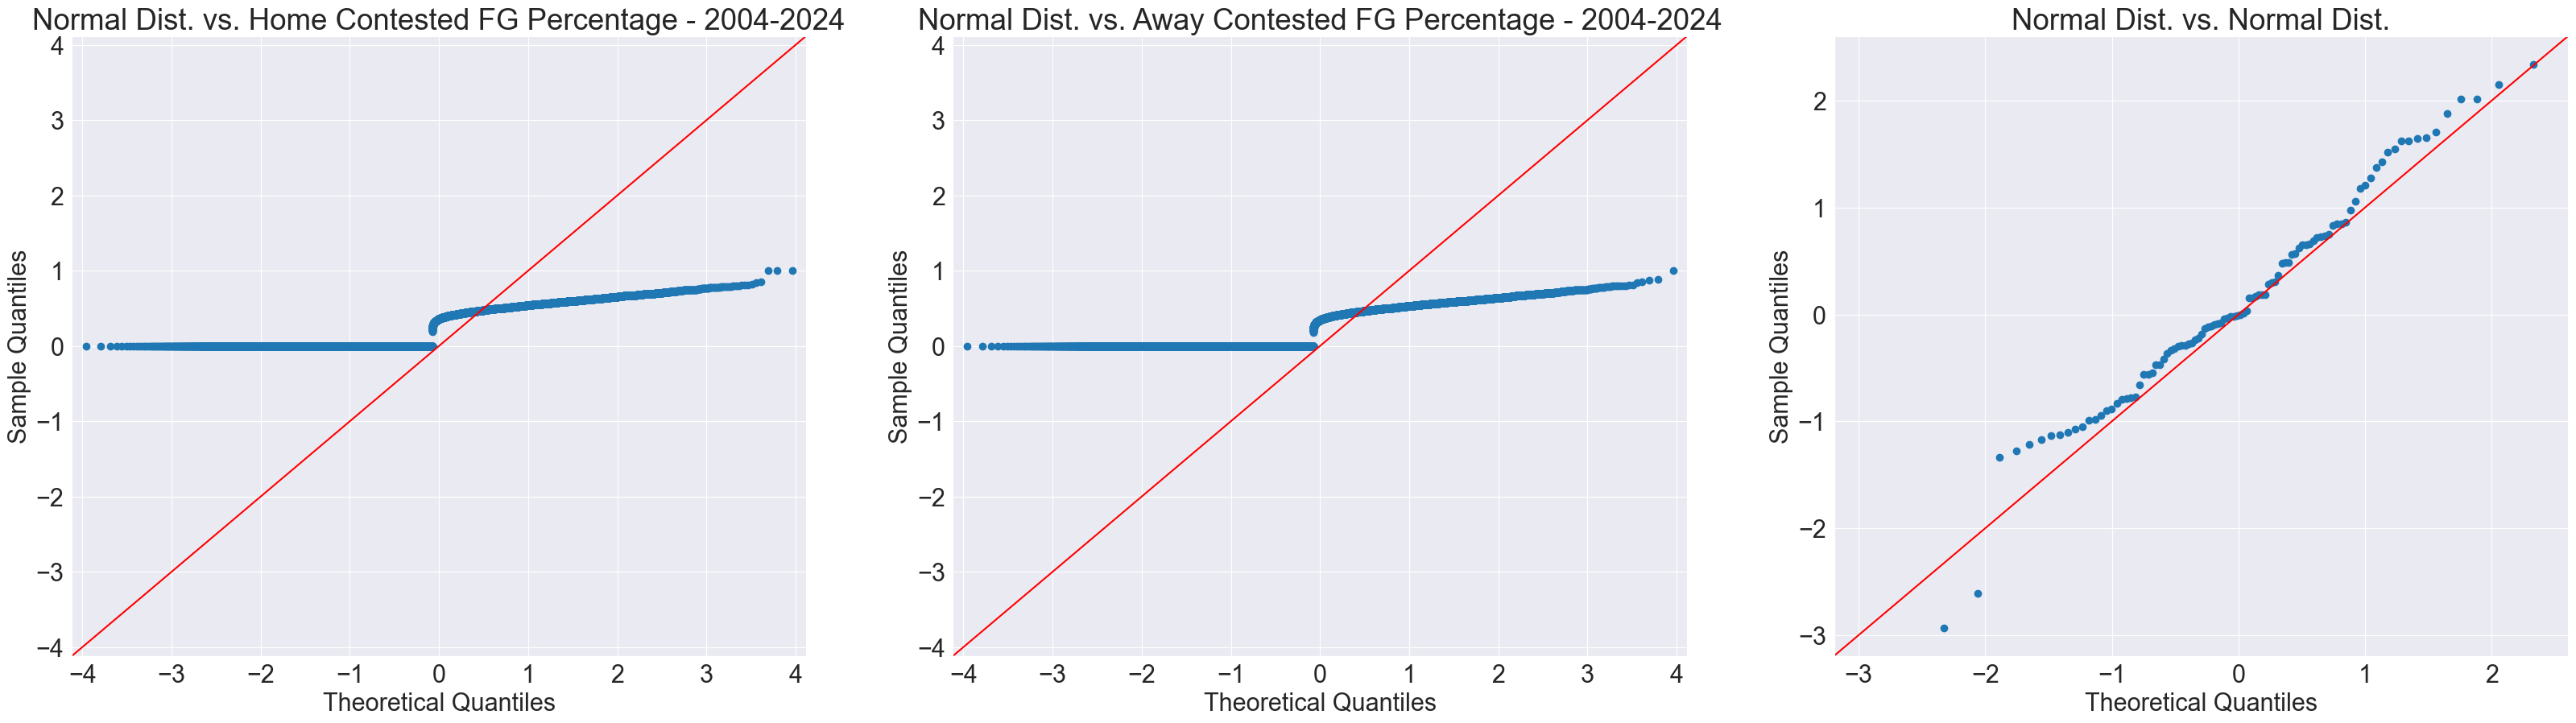

In [38]:
side_by_side_hists(l_cfg, ['Home Contested Field Goal Percentage','Away Contested Field Goal Percentage'])
side_by_side_qq_plots(l_cfg, ['Home Contested FG Percentage','Away Contested FG Percentage'])

**Histograms:** Appears Not Normal

**QQ Plots:** Appears Not Normal

In [39]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_cfg)
print('\033[1mAnderson-Darling:')
run_ad_test(l_cfg)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.7771962628308322,
  p-value: 1.878561458800572e-102

Away Games:
  Test Stat (W): 0.7789969627078522,
  p-value: 3.0298206538258844e-102

Anderson-Darling:
Home Games:
  Test Statistic: 2746.3730695404884,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 2714.6236284513543,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=2746.3730695404884, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.26246550752938524, scale=0.2557651342041032)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=2714.6236284513543, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.25686462127755455, scale=0.2507148252002122)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

#### 4.a.vii. Uncontested Field Goal Percentage

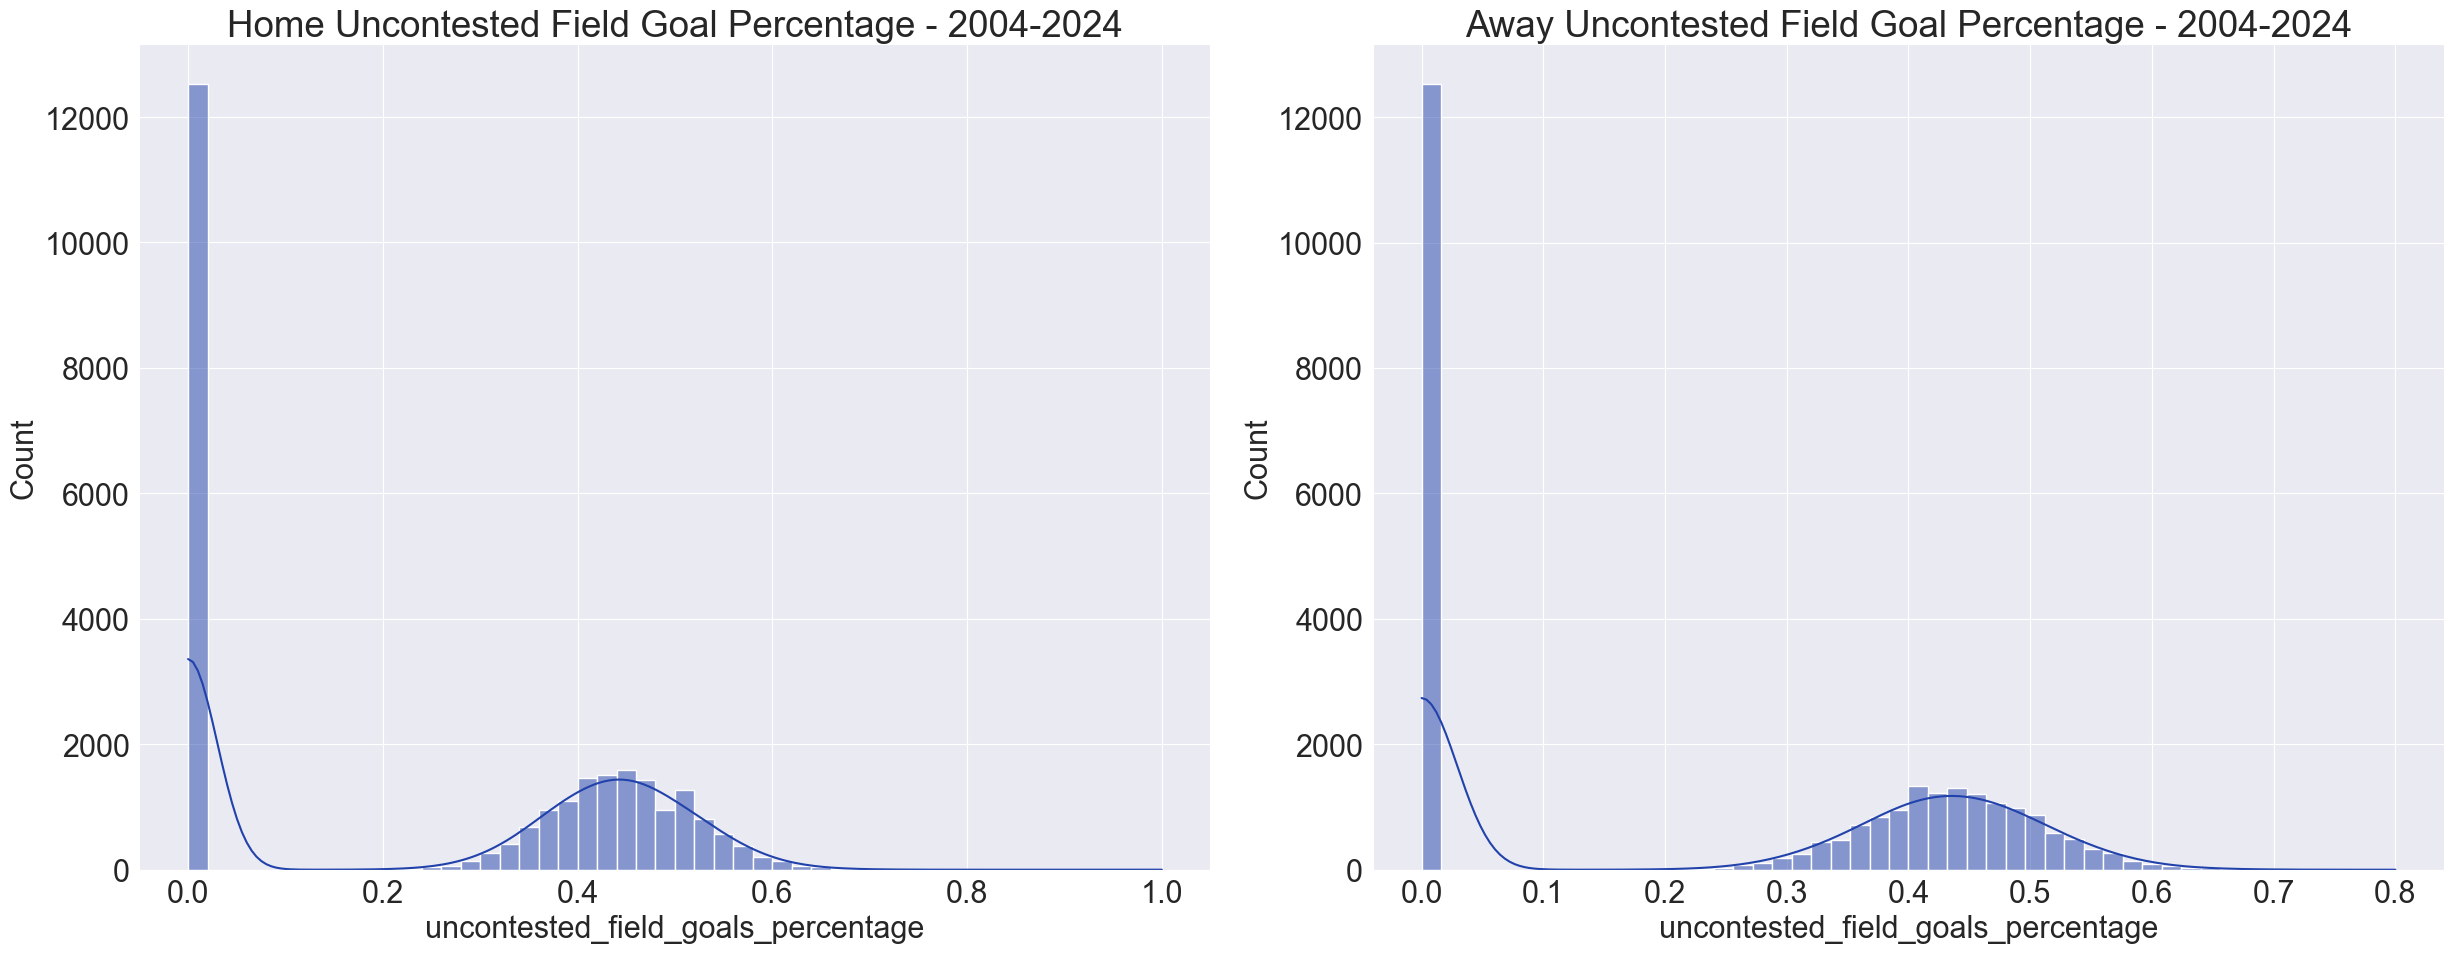

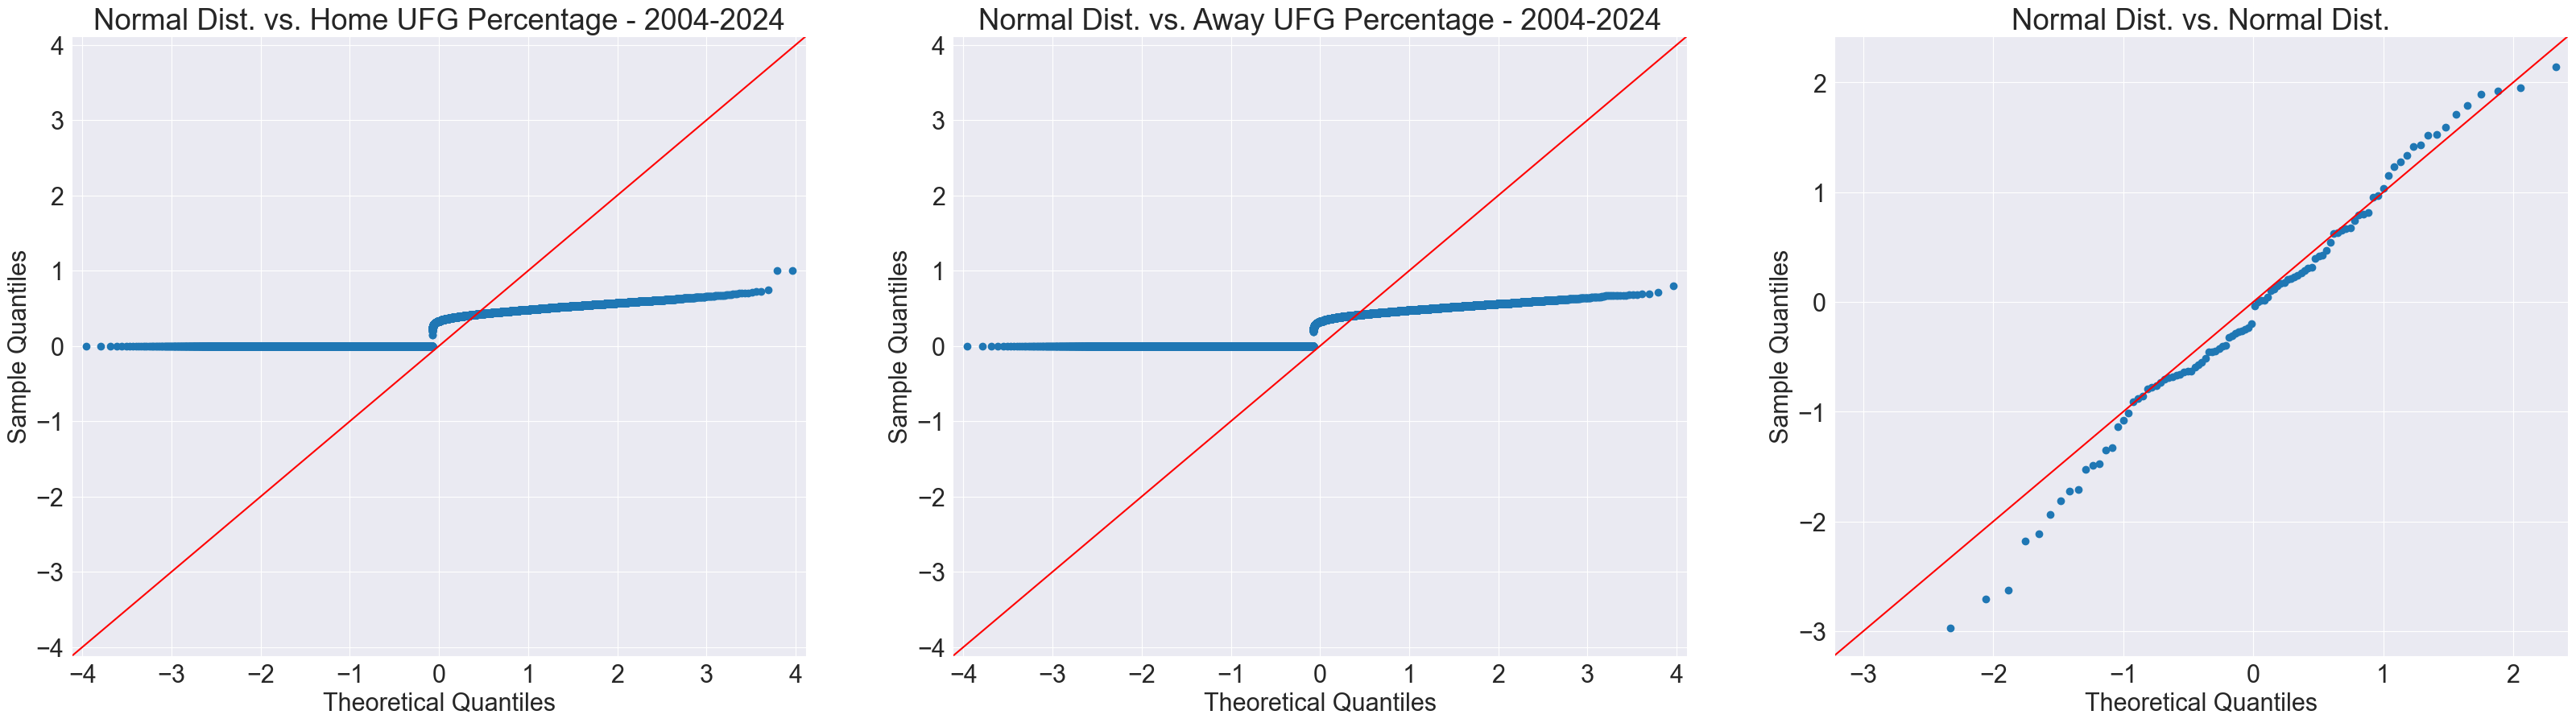

In [40]:
side_by_side_hists(l_ufg, ['Home Uncontested Field Goal Percentage','Away Uncontested Field Goal Percentage'])
side_by_side_qq_plots(l_ufg, ['Home UFG Percentage','Away UFG Percentage'])

**Histograms:** Appears Not Normal

**QQ Plots:** Appears Not Normal

In [41]:
print('\033[1mShapiro-Wilks:')
run_shapiro_test(l_ufg)
print('\033[1mAnderson-Darling:')
run_ad_test(l_ufg)

Shapiro-Wilks:
Home Games:
  Test Stat (W): 0.7672600137952956,
  p-value: 1.4256248874955692e-103

Away Games:
  Test Stat (W): 0.7664273606305956,
  p-value: 1.153644775639896e-103

Anderson-Darling:
Home Games:
  Test Statistic: 2880.562544519511,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]

Home Games:
  Test Statistic: 2888.399295834388,
  Critical Values: [0.576 0.656 0.787 0.918 1.092],
  Significance Level: [15.  10.   5.   2.5  1. ]



/Users/dB/Documents/repos/github/bint-capstone/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26629.
  res = hypotest_fun_out(*samples, **kwds)


(AndersonResult(statistic=2880.562544519511, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.2357571820196027, scale=0.22849163177260096)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'),
 AndersonResult(statistic=2888.399295834388, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.23144376431709793, scale=0.22426713127615833)
  success: True
  message: '`anderson` successfully fit the distribution to the data.'))

**Home**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

**Away**
- Shapiro-Wilks: Reject the Null
- AD Test: Reject the Null

*Therefore, we can assume the data is not normally distributed.*

Now that each distribution has been examined, we can confirm that none of the features are normally distributed, and thus will be tested in the hypothesis testing section with non-parametric tests.

## 5. Hypothesis Testing

For hypothesis testing, we will be testing for differences in group means and variances for home and away field goals, three pointers, free throws, offensive and defensive rebounds, and contested and uncontested field goals. Because no distribution is normally distributed, we will perform these hypothesis tests using non-parametric tests. These tests are the **Levene's Test** for group variances, the **Kruskal-Wallis Test** for group means, and **Dunn's Test** for posthoc analysis.

**Each function will take in a significance level, we are defaulting to a value of .05**

### 5.a. Definitions and Functions

**Kruskal-Wallis Test**

The Kruskal Wallis Test is essentially a non-parametric ANOVA test, meaning the test analyzes group means without assuming normality in distributions. It does this by computing a test-statistic, $H$, and has hypotheses:

$$
\begin{align*}
H_0&\text{:}\mu_{g1} = \mu_{g2} = \cdots = \mu_{gk}  \\
H_1&\text{: At least one group has a different mean} \\
\end{align*}
$$

The following function will take in a list of `pandas.Series` objects of each feature, and will run the `scipy.stats.kruskal` function to retrieve the results. If the p-value of the test is below the significance level, then we reject the null hypothesis and cannot assume group mean equality. If the Null Hypothesis is rejected, **Dunn's Test** must be run as a posthoc analysis to determine how the group means differ.

In [42]:
def run_kw_test_on_home_vs_away(l:list, alpha:float=.05):
    home = l[0]
    away = l[1]

    kw = stats.kruskal(home, away)
    print(f'Kruskal-Wallis Test Results:\n  Test Statistic (H): {kw.statistic}\n  p-value: {kw.pvalue}\n')

    if(kw.pvalue < alpha): # reject
        print(f'Given a p-value of {kw.pvalue} < {alpha}, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.')
    else: # accept
        print(f'Given a p-value of {kw.pvalue} >= {alpha}, we fail to reject the null hypothesis. Each group is likely to have the same mean.')
    return kw

**Levene's Test**

Levene's Test is a statistical test used to check equality of variances between groups, and will be used to check if variances between home and away games are the same. This is done by computing a test statistic, $W$, and has hypotheses:

$$
\begin{align*}
H_0&\text{: }\sigma_{g1}^2 = \sigma_{g2}^2 = \cdots = \sigma_{gk}^2 \\
H_1&\text{: At least one group has a different variance}
\end{align*}
$$

The following function takes in a list of `pandas.Series` features, and runs the `scipy.stats.levene` function to retrieve the test results. If the p-value of the test is less than the significance level, then we reject the null hypothesis and cannot assume group variance equality. If the null hypothesis is rejected, posthoc tests may need to be run.

In [43]:
def run_levene_test_home_vs_away(l:list, alpha:float=.05):
    home = l[0]
    away = l[1]

    lev = stats.levene(home, away)
    print(f'Levene Test Results:\n  Test Statistic (W): {lev.statistic}\n  p-value: {lev.pvalue}\n')

    if(lev.pvalue < alpha): # reject
        print(f'Given a p-value of {lev.pvalue} < {alpha}, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.')
    else: # accept
        print(f'Given a p-value of {lev.pvalue} >= {alpha}, we fail to reject the null hypothesis. Each group is likely to have the same variance.')
    return lev

**Dunn's Test**

Dunn's Test conducts a posthoc analysis of the group means after a **Kruskal-Wallis** one-way ANOVA to see how group means differ.

$$
\begin{align*}
H_0&\text{: }\mu_{g1} = \mu_{g2} \\
H_1&\text{: }\mu_{g1} \neq \mu_{g2} \\
\end{align*}
$$

The following function uses the `scikit_posthoc` package's `posthoc_dunn` function and returns the results.

In [44]:
def run_dunn_test(l:list):
    import scikit_posthocs as sp
    data = [l[0],l[1]]
    x = sp.posthoc_dunn(data, p_adjust='holm')

    # Interpretation
    print(f'Dunn Test Results:\n')

    for i in range(len(x)):
        for j in range(len(x)):
            if i != j:  # Ignore diagonal values
                p_value = x.iloc[i, j]
                print(f"Comparison between Group {i+1} and Group {j+1}:")
                print(f"  - p-value: {p_value:.2e}")

                if p_value < 0.05:
                    print("  - Significant difference found (p < 0.05).")
                else:
                    print("  - No significant difference (p >= 0.05).")

                print()
                
    
    print(f'Table:\n{x}')
    return x

**Conover's Test**

Conover's test is a non-parametric posthoc test to be used when Levene's test discovers significant differences in group variances. We can again use `scikit_posthocs` in the function to compare group variances.

In [45]:
def run_conover_test(l:list):
    import scikit_posthocs as sp
    data = [l[0],l[1]]

    res = sp.posthoc_conover(data)
    print('Conover Results:\n',res)

    for i in range(len(res)):
        for j in range(len(res)):
            if i != j:  # Ignore diagonal values
                p_val = res.iloc[i, j]
                print(f"Comparison between Group {i+1} and Group {j+1}:")
                print(f"  - p-value: {p_val:.2e}")

                if p_val < 0.05:
                    print("  - Significant variance difference (p < 0.05).")
                else:
                    print("  - No significant variance difference (p >= 0.05).")
                print()

    return res

### 5.b. Conducting Hypothesis Tests

Now that each function is defined, we can run the hypothesis tests on each set of features. We will create a list of each test statistic and result.

In [46]:
kw_list = []
dunn_list = []
levene_list = []
conover_list = []

#### 5.b.i. Field Goal Percentage

In [47]:
kw_list.append(run_kw_test_on_home_vs_away(l_fg))
print()
dunn_list.append(run_dunn_test(l_fg))
print()
levene_list.append(run_levene_test_home_vs_away(l_fg))
print()
conover_list.append(run_conover_test(l_fg))

Kruskal-Wallis Test Results:
  Test Statistic (H): 451.0892652668235
  p-value: 4.178899721663277e-100

Given a p-value of 4.178899721663277e-100 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 4.18e-100
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 4.18e-100
  - Significant difference found (p < 0.05).

Table:
               1              2
1   1.000000e+00  4.178900e-100
2  4.178900e-100   1.000000e+00

Levene Test Results:
  Test Statistic (W): 9.111417596142303
  p-value: 0.002541390687318563

Given a p-value of 0.002541390687318563 < 0.05, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.

Conover Results:
                1              2
1   1.000000e+00  1.605940e-100
2  1.605940e-100   1.000000e+00
Comparison between Group 1 and Group 2:
  - p-value:

#### 5.b.ii. Three Pointer Percentage

In [48]:
kw_list.append(run_kw_test_on_home_vs_away(l_tp))
print()
dunn_list.append(run_dunn_test(l_tp))
print()
levene_list.append(run_levene_test_home_vs_away(l_tp))
print()
conover_list.append(run_conover_test(l_tp))

Kruskal-Wallis Test Results:
  Test Statistic (H): 54.91753134544615
  p-value: 1.2569479907736387e-13

Given a p-value of 1.2569479907736387e-13 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 1.26e-13
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 1.26e-13
  - Significant difference found (p < 0.05).

Table:
              1             2
1  1.000000e+00  1.256948e-13
2  1.256948e-13  1.000000e+00

Levene Test Results:
  Test Statistic (W): 3.623790223557848
  p-value: 0.05696435433949042

Given a p-value of 0.05696435433949042 >= 0.05, we fail to reject the null hypothesis. Each group is likely to have the same variance.

Conover Results:
               1             2
1  1.000000e+00  1.239933e-13
2  1.239933e-13  1.000000e+00
Comparison between Group 1 and Group 2:
  - p-value: 1.24e-13
  - Significant v

#### 5.b.iii. Free Throw Percentage

In [49]:
kw_list.append(run_kw_test_on_home_vs_away(l_ft))
print()
dunn_list.append(run_dunn_test(l_ft))
print()
levene_list.append(run_levene_test_home_vs_away(l_ft))
print()
conover_list.append(run_conover_test(l_ft))

Kruskal-Wallis Test Results:
  Test Statistic (H): 8.859309000168757
  p-value: 0.0029159793833937143

Given a p-value of 0.0029159793833937143 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 2.92e-03
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 2.92e-03
  - Significant difference found (p < 0.05).

Table:
          1         2
1  1.000000  0.002916
2  0.002916  1.000000

Levene Test Results:
  Test Statistic (W): 15.623983046841259
  p-value: 7.736802420536903e-05

Given a p-value of 7.736802420536903e-05 < 0.05, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.

Conover Results:
           1         2
1  1.000000  0.002915
2  0.002915  1.000000
Comparison between Group 1 and Group 2:
  - p-value: 2.92e-03
  - Significant variance difference (p < 0.05).

Co

#### 5.b.iv. Offensive Rebounds

In [50]:
kw_list.append(run_kw_test_on_home_vs_away(l_r_off))
print()
dunn_list.append(run_dunn_test(l_r_off))
print()
levene_list.append(run_levene_test_home_vs_away(l_r_off))
print()
conover_list.append(run_conover_test(l_r_off))

Kruskal-Wallis Test Results:
  Test Statistic (H): 72.98160832260439
  p-value: 1.30863637301333e-17

Given a p-value of 1.30863637301333e-17 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 1.31e-17
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 1.31e-17
  - Significant difference found (p < 0.05).

Table:
              1             2
1  1.000000e+00  1.308636e-17
2  1.308636e-17  1.000000e+00

Levene Test Results:
  Test Statistic (W): 10.259790527762055
  p-value: 0.001360410633419363

Given a p-value of 0.001360410633419363 < 0.05, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.

Conover Results:
               1             2
1  1.000000e+00  1.277197e-17
2  1.277197e-17  1.000000e+00
Comparison between Group 1 and Group 2:
  - p-value: 1.28e-17
  - Sig

#### 5.b.v. Defensive Rebounds

In [51]:
kw_list.append(run_kw_test_on_home_vs_away(l_r_def))
print()
dunn_list.append(run_dunn_test(l_r_def))
print()
levene_list.append(run_levene_test_home_vs_away(l_r_def))
print()
conover_list.append(run_conover_test(l_r_def))

Kruskal-Wallis Test Results:
  Test Statistic (H): 377.9813431926601
  p-value: 3.4233995734754624e-84

Given a p-value of 3.4233995734754624e-84 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 3.42e-84
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 3.42e-84
  - Significant difference found (p < 0.05).

Table:
              1             2
1  1.000000e+00  3.423400e-84
2  3.423400e-84  1.000000e+00

Levene Test Results:
  Test Statistic (W): 2.6891863580890796
  p-value: 0.10103729792712898

Given a p-value of 0.10103729792712898 >= 0.05, we fail to reject the null hypothesis. Each group is likely to have the same variance.

Conover Results:
               1             2
1  1.000000e+00  1.751313e-84
2  1.751313e-84  1.000000e+00
Comparison between Group 1 and Group 2:
  - p-value: 1.75e-84
  - Significant 

#### 5.b.vi. Contested Field Goals

In [52]:
kw_list.append(run_kw_test_on_home_vs_away(l_cfg))
print()
dunn_list.append(run_dunn_test(l_cfg))
print()
levene_list.append(run_levene_test_home_vs_away(l_cfg))
print()
conover_list.append(run_conover_test(l_cfg))

Kruskal-Wallis Test Results:
  Test Statistic (H): 14.541402826819224
  p-value: 0.00013711287592163806

Given a p-value of 0.00013711287592163806 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 1.37e-04
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 1.37e-04
  - Significant difference found (p < 0.05).

Table:
          1         2
1  1.000000  0.000137
2  0.000137  1.000000

Levene Test Results:
  Test Statistic (W): 20.754246267392045
  p-value: 5.233134763320045e-06

Given a p-value of 5.233134763320045e-06 < 0.05, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.

Conover Results:
           1         2
1  1.000000  0.000137
2  0.000137  1.000000
Comparison between Group 1 and Group 2:
  - p-value: 1.37e-04
  - Significant variance difference (p < 0.05).


#### 5.b.vii. Uncontested Field Goals

In [53]:
kw_list.append(run_kw_test_on_home_vs_away(l_ufg))
print()
dunn_list.append(run_dunn_test(l_ufg))
print()
levene_list.append(run_levene_test_home_vs_away(l_ufg))
print()
conover_list.append(run_conover_test(l_ufg))

Kruskal-Wallis Test Results:
  Test Statistic (H): 13.22720982951576
  p-value: 0.00027591423166983706

Given a p-value of 0.00027591423166983706 < 0.05, we reject the null hypothesis. At least one group has a different mean, conduct posthoc tests.

Dunn Test Results:

Comparison between Group 1 and Group 2:
  - p-value: 2.76e-04
  - Significant difference found (p < 0.05).

Comparison between Group 2 and Group 1:
  - p-value: 2.76e-04
  - Significant difference found (p < 0.05).

Table:
          1         2
1  1.000000  0.000276
2  0.000276  1.000000

Levene Test Results:
  Test Statistic (W): 14.548928770896513
  p-value: 0.0001367202815042094

Given a p-value of 0.0001367202815042094 < 0.05, we reject the null hypothesis. At least one group has a different variance, conduct posthoc tests.

Conover Results:
           1         2
1  1.000000  0.000276
2  0.000276  1.000000
Comparison between Group 1 and Group 2:
  - p-value: 2.76e-04
  - Significant variance difference (p < 0.05).



### 5.c. Conclusion

Given the results of the above distribution and hypothesis testing, we see that the statistics chosen are not normally distributed, and differ significantly in both mean and variance between Home and Away games. This indicates that there is a significant difference in these game types that should be examined further, and that these stats could indicate a reason why home game win rates have declined over time.

## 6. Cleaning Up Test Results for CrossTabs

In [54]:
l_shapiro

NameError: name 'l_shapiro' is not defined

In [ ]:
# Reading crosstabs

norm_df = pd.read_excel('/Users/dB/Documents/repos/github/bint-capstone/data-sources/crosstabs.xlsx',sheet_name='normality')
norm_df

,Statistic,Shapiro pvalue,AD Test Statistic,AD Critical Values
0,Field Goal Percentage (HOME),8.095310e-12,7.121833,[0.576 0.656 0.787 0.918 1.092]
1,Three Point Percentage (HOME),1.013159e-02,18.077888,[0.576 0.656 0.787 0.918 1.092]
2,Defensive Rebounds (HOME),6.431824e-48,132.236313,[0.576 0.656 0.787 0.918 1.092]
3,Field Goal Percentage (AWAY),1.713423e-07,3.764704,[0.576 0.656 0.787 0.918 1.092]
4,Three Point Percentage (AWAY),7.834584e-24,14.524985,[0.576 0.656 0.787 0.918 1.092]
5,Defensive Rebounds (AWAY),7.993993e-49,141.451493,[0.576 0.656 0.787 0.918 1.092]


In [ ]:
hypo_df = pd.read_excel('/Users/dB/Documents/repos/github/bint-capstone/data-sources/crosstabs.xlsx', sheet_name='hypothesis')
hypo_df

,Statistic,Kruskal-Wallis,Dunn Test,Levene Test,Conover Test
0,Field Goal Percentage,4.178900e-100,4.180000e-100,0.002541,1.610000e-100
1,Three Pointer Percentage,1.256948e-13,1.260000e-13,0.056964,NaN
2,Defensive Rebound Percentage,3.423400e-84,3.420000e-84,0.101037,NaN


# References

Statistical Tests:

- **Shapiro-Wilk Test**
  - [Docs](<https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.stats.shapiro.html>)
  - [Wikipedia Article](<https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test>)
- **Anderson-Darling Test**
  - [Docs](<https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.stats.anderson.html>)
  - [Wikipedia Article](<https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test>)
- **Kruskal-Wallis Test**
  - [Docs](<https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal>)
  - [Wikipedia Article](<https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test>)
- **Levene's Test**
  - [Docs](<https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.stats.levene.html#scipy.stats.levene>)
  - [Wikipedia Article](<https://en.wikipedia.org/wiki/Levene%27s_test>)
- **Dunn's Test**
  - [Docs](<https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html>)
  - [Statology.org Article](<https://www.statology.org/dunns-test/>)
- **Conover's Test**
  - [Docs](<https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_conover.html>)
  - [PQStat Manual](<https://manuals.pqstat.pl/en:statpqpl:porown3grpl:nparpl:conovervar>)
- [Scipy.stats Documentation](<https://docs.scipy.org/doc/scipy-1.12.0/reference/stats.html>)
- [Scikit_posthocs Documentation](<https://scikit-posthocs.readthedocs.io/en/latest/posthocs_api.html>)

In [ ]:
cleaned

NameError: name 'cleaned' is not defined